<a href="https://colab.research.google.com/github/lluisdn/TFM/blob/Calibration/temperature_calibration_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pre models**

##**Imports**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
#from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
import json
with open('dataset_infos.json', 'r') as file:
    label = json.load(file)
    labels = label["CIFAR100"]
    label_strings = np.array(label["CIFAR100"])

##**Pre-process**

In [ ]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

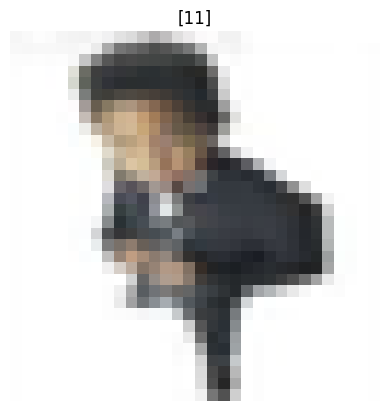

['man']


In [ ]:
num_classes = 100
nb_epochs = 10

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_test, x_calibration, y_test, y_calibration = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

num=1
plt.figure()
plt.imshow(x_test[num])
plt.axis("off")
plt.title(y_test[num])
plt.show()

#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
x_calibration = preprocess_input(x_calibration)
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)

y_train_hot_encoded = np_utils.to_categorical(y_train, num_classes)
y_test_hot_encoded = np_utils.to_categorical(y_test, num_classes)
y_calibration_hot_encoded = np_utils.to_categorical(y_calibration, num_classes)


bool_array = (np.argmax(y_calibration_hot_encoded, axis=1)[:,None] == np.arange(y_test_hot_encoded.shape[1]))
print(label_strings[bool_array[num]])

#**Load model**

In [ ]:
model = tf.keras.models.load_model('my_model.h5')

In [ ]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy'])#,top3_acc])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_3 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 up_sampling2d_4 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 up_sampling2d_5 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                             

##**Probabilities prediccions**



In [ ]:
model.evaluate(x_test, y_test_hot_encoded, batch_size=64)
probs_y_test=model.predict(x_test)
probs_y_calibration = model.predict(x_calibration)
probs_y_train = model.predict(x_train)

1563/1563 [==============================] - 174s 111ms/step


In [ ]:
print(probs_y_test[1])

[4.3340254e-08 8.2677286e-07 2.9269855e-02 5.0673807e-06 1.5031388e-05
 8.7053883e-07 4.3346081e-06 7.5586416e-07 1.8258199e-06 1.7351326e-06
 4.4791372e-07 3.8880965e-01 3.1912833e-07 3.9646758e-07 3.8976277e-06
 1.3060773e-06 7.3859374e-06 1.1148376e-06 1.1516736e-07 3.7356702e-05
 3.3524196e-04 1.3335850e-04 2.9549159e-05 7.0791216e-06 2.3841267e-06
 2.4873776e-05 9.0935691e-06 5.7394058e-08 1.3483092e-06 5.1000134e-06
 1.6328045e-07 1.2476935e-06 1.5117933e-05 2.6812958e-07 4.5743422e-05
 4.7571827e-02 3.7585116e-05 1.9400659e-06 1.4508745e-05 4.6071993e-05
 1.2000984e-03 5.7155019e-05 1.0571521e-06 1.6702745e-05 4.5365045e-08
 1.9699692e-06 6.8949513e-02 4.2049419e-06 2.4549709e-07 3.3017417e-07
 1.1583718e-05 5.4244647e-06 4.4025765e-07 1.4121713e-06 1.1808521e-04
 1.3324840e-06 2.5798229e-08 1.1218297e-06 8.8019455e-08 4.0137789e-07
 8.6400399e-07 1.0711641e-06 1.1059742e-06 1.9546229e-07 2.6020078e-07
 1.2949151e-06 1.2644377e-05 2.7245622e-07 6.4579865e-08 3.3981243e-05
 1.766

#**Save and load the logits model**

In [ ]:
print(model.layers[-1].activation)
model.layers[-1].activation = tf.keras.activations.linear
print(model.layers[-1].activation)
model.save('model_logits10.h5')


<function softmax at 0x7fdd6b566830>
<function linear at 0x7fdd6b567c70>


In [ ]:
logits_model = tf.keras.models.load_model('model_logits10.h5')

##**Logits prediccions**

In [ ]:
x_train_logits=logits_model.predict(x_train)
x_test_logits=logits_model.predict(x_test)
x_calibration_logits=logits_model.predict(x_calibration)
logits_model.evaluate(x_train, y_train_hot_encoded, batch_size=64)
logits_model.evaluate(x_test, y_test_hot_encoded, batch_size=64)
logits_model.evaluate(x_calibration, y_calibration_hot_encoded, batch_size=64)

32/32 [==============================] - 7s 217ms/step - loss: 15.1777 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685


[15.17770004272461, 0.800000011920929, 0.968500018119812]

In [ ]:
import numpy as np

# Assume we have two arrays a and b
a=probs_y_test
print(probs_y_test.shape)
b=y_test_hot_encoded
print(y_test_hot_encoded.shape)
# Create a new 2D array where the first column is a1 and the second column is b1
framework = np.column_stack((a[0], b[0]))

# Loop through the remaining elements of a and b and append them to the framework array
for i in range(1, len(a)):
    row = np.column_stack((a[i], b[i]))
    framework = np.vstack((framework, row))

# Save the framework array to an npy file
np.save('framework.npy', framework)

(8000, 100)
(8000, 100)


In [ ]:
framework = np.load('framework.npy')

probs_y_test = framework[:, 0].reshape((8000, 100))
y_test_hot_encoded = framework[:, 1].reshape((8000, 100))

print(probs_y_test)
print(y_test_hot_encoded)
print(probs_y_test)

[[2.37711309e-03 2.14213310e-06 2.21794949e-07 ... 5.38327508e-11
  1.33486511e-08 2.64085340e-08]
 [4.33408047e-08 8.26779456e-07 2.92694215e-02 ... 6.54291898e-06
  4.62734282e-01 3.19283089e-07]
 [7.03242531e-09 4.08263312e-10 5.44539080e-09 ... 1.06101003e-10
  2.44286125e-09 9.99747694e-01]
 ...
 [9.80403259e-12 1.85957486e-10 1.17741164e-10 ... 2.78840834e-13
  4.75025436e-11 1.07599658e-11]
 [8.47621834e-07 6.10093994e-04 7.66911762e-06 ... 3.17700596e-07
  5.19962207e-08 6.60008984e-04]
 [1.37531755e-08 7.58204376e-04 6.94768460e-07 ... 9.75673320e-05
  2.59384496e-08 2.97849567e-08]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


AttributeError: ignored

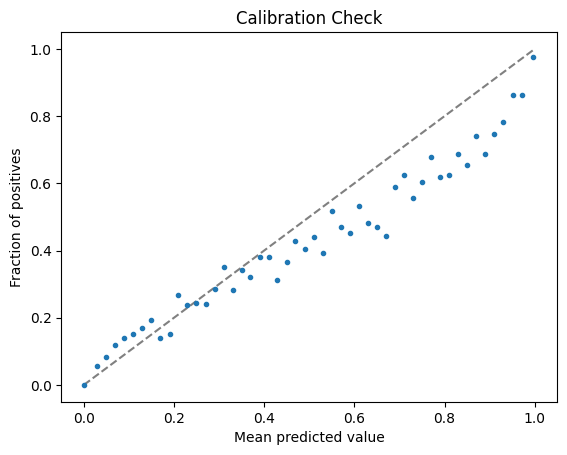

In [ ]:
probs_array_vanila, y_test_array_vanila = pre_calibration(probs_y_test, y_test_hot_encoded)
ModelCalibration(probs_array_vanila, y_test_array_vanila)

In [ ]:
print('The expected calibration error of the Vanila model is:',expected_calibration_error(probs_y_test, y_test_hot_encoded,10))

print('The maximum calibration error of the Vanila model is:',max_calibration_error(probs_y_test, y_test_hot_encoded, 10))

The expected calibration error of the Vanila model is: 0.14107361823441533
The maximum calibration error of the Vanila model is: 0.17203545570373535


#**Temperature model**

##**Class temperature layer**

In [ ]:
class CustomLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(CustomLayer, self).__init__()
    super(CustomLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.T = self.add_weight("T", shape=[1])

  def call(self, inputs):
    return tf.keras.activations.softmax(inputs/tf.keras.activations.softplus(self.T))

##**Model**

In [ ]:
model_temperature = Sequential()
model_temperature.add(CustomLayer())
model_temperature.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy'])#,top3_acc])


##**Training**

In [ ]:
history = model_temperature.fit(x_calibration_logits, y_calibration_hot_encoded,epochs=10)
#As we can see the accuracy of the model do NOT change

Epoch 1/10
63/63 [==============================] - 1s 3ms/step - loss: 0.8652 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 0.8458 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 0.8277 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 0.8116 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 0.7969 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 6/10
63/63 [==============================] - 0s 3ms/step - loss: 0.7841 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.7727 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.9685
Epoch 8/10
63/63 [==============================] - 0s 

##**Save and load the temperature model**

In [ ]:
model_temperature.save('model_temperature.h5')

In [ ]:
model_temperature = tf.keras.models.load_model('model_temperature.h5', custom_objects={'CustomLayer': CustomLayer} )

In [ ]:
model_temperature.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_layer_1 (CustomLayer  (None, 100)              1         
 )                                                               
                                                                 
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


###**Temperatures probs**

In [ ]:
probs_temp_y_test=model_temperature.predict(x_test_logits)
model_temperature.evaluate(x_test_logits, y_test_hot_encoded, batch_size=64)

125/125 [==============================] - 0s 2ms/step - loss: 0.7114 - accuracy: 0.8036 - top_k_categorical_accuracy: 0.9675


[0.7113704681396484, 0.8036249876022339, 0.9674999713897705]

#**Matrix scaling model**

##**Model**

In [ ]:
model_matrix = Sequential()
model_matrix.add(Dense(100,activation='softmax')) #Matrix scaling
model_matrix.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy'])#,top3_acc])

##**Training**

In [ ]:
history = model_matrix.fit(x_calibration_logits, y_calibration_hot_encoded,epochs=10)
#As we can see the accuracy of the model DO change

Epoch 1/10
63/63 [==============================] - 1s 4ms/step - loss: 8.3711 - accuracy: 0.0335 - top_k_categorical_accuracy: 0.1365
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 4.4537 - accuracy: 0.1720 - top_k_categorical_accuracy: 0.4150
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 2.7422 - accuracy: 0.3390 - top_k_categorical_accuracy: 0.6585
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 1.9101 - accuracy: 0.4835 - top_k_categorical_accuracy: 0.8025
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 1.4697 - accuracy: 0.5840 - top_k_categorical_accuracy: 0.8720
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 1.1965 - accuracy: 0.6610 - top_k_categorical_accuracy: 0.9135
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 1.0157 - accuracy: 0.7150 - top_k_categorical_accuracy: 0.9280
Epoch 8/10
63/63 [==============================] - 0s 

In [ ]:
model_matrix.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
Total params: 10,100
Trainable params: 10,100
Non-trainable params: 0
_________________________________________________________________


##**Save and Load the matrix scaling model**


In [ ]:
model_matrix.save('model_matrix.h5')

In [ ]:
model_matrix = tf.keras.models.load_model('model_matrix.h5')

In [ ]:
model_matrix.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
Total params: 10,100
Trainable params: 10,100
Non-trainable params: 0
_________________________________________________________________


###**Matrix probs**

In [ ]:
probs_matrix_y_test=model_matrix.predict(x_test_logits)
model_matrix.evaluate(x_test_logits, y_test_hot_encoded, batch_size=64)

125/125 [==============================] - 0s 2ms/step - loss: 1.3709 - accuracy: 0.6214 - top_k_categorical_accuracy: 0.8945


[1.3708782196044922, 0.6213750243186951, 0.8945000171661377]

#**Calibration code**

In [ ]:
def pre_calibration(probs, labels):
  probs_array=[]
  labels_array=[]
  i=0
  j=0
  for i in range(len(probs)):
    for j in range(len(probs[0])):
      probs_array.append(probs[i][j])
      labels_array.append(labels[i][j])   #HOT ENCODED ARRAY!!!!!!!!!!!!!!!
  return probs_array, labels_array

In [ ]:
def ModelCalibration(y_prob, y_true):
  # y_true: true labels, y_prob: predicted probabilities
  n_bins = 50  # number of bins
  bin_size = 1 / n_bins  # size of each bin

  bins = np.linspace(0, 1, n_bins+1)  # define the bin edges
  bin_centers = np.linspace(bin_size/2, 1-bin_size/2, n_bins)  # define the bin centers

  # Compute the mean predicted probability and the true frequency for each bin
  mean_predicted_value = []
  fraction_of_positives = []

  for bin_start, bin_end in zip(bins[:-1], bins[1:]):
      idx = (y_prob >= bin_start) & (y_prob < bin_end)  # indices of the examples in the current bin
      result = [y_prob[i] for i in range(len(y_prob)) if idx[i]]
      #print(result)
      true = [y_true[i] for i in range(len(y_prob)) if idx[i]]
      #print(true)
      #print()
      if np.sum(idx) == 0:  # if there are no examples in the bin, skip it
          continue

      mean_predicted_value.append(np.mean(result))          # mean predicted probability for the current bin

      fraction_of_positives.append(np.sum(true)/np.sum(idx))      #np.sum(y_true[idx]) / np.sum(idx))  # true frequency for the current bin
      #print(bin_start, bin_end)
      #print(len(true))
      #print(np.sum(idx))
      #print(fraction_of_positives)


  # Plot the reliability diagram
  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
  ax.plot(mean_predicted_value, fraction_of_positives, ".")

  ax.set_xlabel('Mean predicted value')
  ax.set_ylabel('Fraction of positives')
  ax.set_title('Calibration Check')

  plt.show()


##**Vanila model**

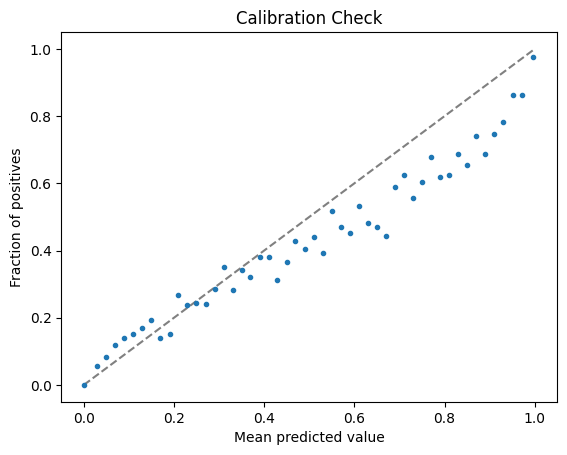

In [ ]:
probs_array_vanila, y_test_array_vanila = pre_calibration(probs_y_test, y_test_hot_encoded)
ModelCalibration(probs_array_vanila, y_test_array_vanila)

##**Temperature calibration**


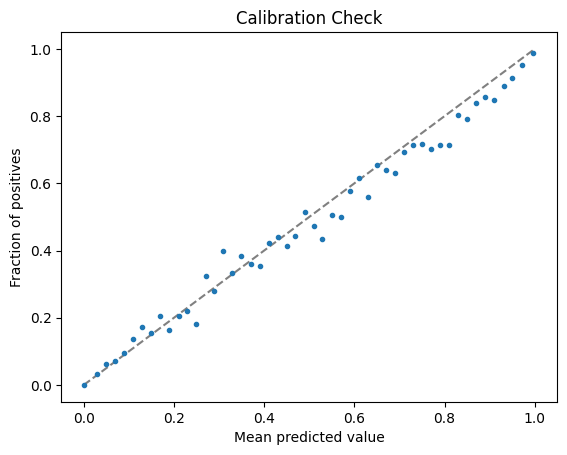

In [ ]:
probs_array_temperature, y_test_array_temperature = pre_calibration(probs_temp_y_test, y_test_hot_encoded)
ModelCalibration(probs_array_temperature, y_test_array_temperature)

##**Matrix calibration**

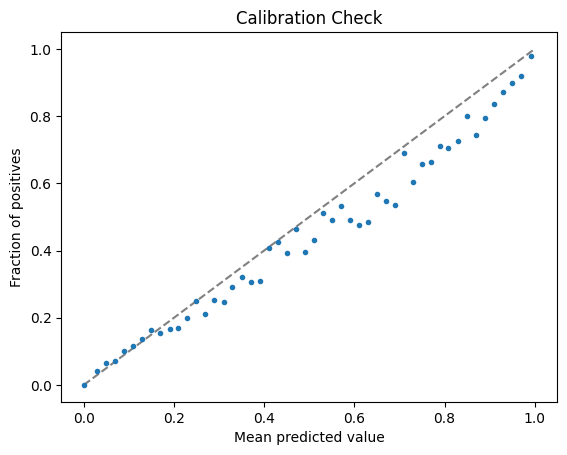

In [ ]:
probs_array_matrix, y_test_array_matrix = pre_calibration(probs_matrix_y_test, y_test_hot_encoded)
ModelCalibration(probs_array_matrix, y_test_array_matrix)

In [ ]:
print(probs_y_test[0])
print(probs_temp_y_test[0])


[2.3771131e-03 2.1421331e-06 2.2179495e-07 5.5553162e-10 4.4478529e-10
 5.7373544e-08 5.4128479e-10 9.7792352e-10 4.1339807e-09 2.2179568e-10
 7.1084901e-06 1.2653625e-06 9.5442916e-09 2.8405796e-07 7.0496981e-07
 1.8465347e-07 5.6019481e-08 1.5671621e-07 5.0591354e-11 4.1727048e-08
 4.5918266e-10 3.5403747e-09 4.7517641e-08 8.7245128e-11 5.3117594e-10
 1.1400879e-05 4.5791850e-08 1.3884583e-12 1.8051484e-09 1.7619547e-08
 4.7437658e-09 8.3263149e-07 3.7644579e-08 3.0796468e-09 3.1247834e-11
 4.0130040e-08 3.5219824e-08 4.2969655e-06 1.7070324e-11 6.2012173e-06
 5.4541971e-07 7.0182660e-10 7.2175121e-10 4.5270657e-10 2.1817928e-10
 8.5171615e-07 4.1312084e-08 9.4567952e-07 3.2900120e-09 3.0924965e-09
 2.8351075e-09 1.4355882e-04 4.1599799e-09 1.3454631e-04 9.7158809e-05
 3.5305275e-10 3.8704675e-07 5.4120028e-04 4.5901857e-08 2.5179681e-09
 1.8526935e-08 1.0192317e-08 2.1999467e-03 8.0747934e-12 6.2057776e-10
 1.2346819e-09 9.7816373e-11 1.8082100e-11 3.5762910e-09 7.4299118e-09
 3.350

#**Save**

In [ ]:
import numpy as np

# Assume we have two arrays a and b
a=probs_temp_y_test
print(probs_temp_y_test.shape)
b=y_test_hot_encoded
print(y_test_hot_encoded.shape)
# Create a new 2D array where the first column is a1 and the second column is b1
framework = np.column_stack((a[0], b[0]))

# Loop through the remaining elements of a and b and append them to the framework array
for i in range(1, len(a)):
    row = np.column_stack((a[i], b[i]))
    framework = np.vstack((framework, row))

# Save the framework array to an npy file
np.save('framework_temperature.npy', framework)

(8000, 100)
(8000, 100)


In [ ]:
import numpy as np

# Assume we have two arrays a and b
a=probs_matrix_y_test
print(probs_matrix_y_test.shape)
b=y_test_hot_encoded
print(y_test_hot_encoded.shape)
# Create a new 2D array where the first column is a1 and the second column is b1
framework = np.column_stack((a[0], b[0]))

# Loop through the remaining elements of a and b and append them to the framework array
for i in range(1, len(a)):
    row = np.column_stack((a[i], b[i]))
    framework = np.vstack((framework, row))

# Save the framework array to an npy file
np.save('framework_matrix.npy', framework)

(8000, 100)
(8000, 100)


#**Calibration error**

##**Expected Calibration error**

In [ ]:
import numpy as np

def expected_calibration_error(probs, labels, num_bins):
    # Step 1: Divide the predicted probabilities into bins.
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(probs, bin_boundaries[1:-1])

    # Step 2: Calculate the average predicted and true probabilities for each bin.
    bin_probs = np.zeros(num_bins)
    bin_accs = np.zeros(num_bins)
    for i in range(num_bins):
        mask = bin_indices == i
        bin_probs[i] = np.mean(probs[mask])
        bin_accs[i] = np.mean(labels[mask])

    # Step 3: Calculate the ECE as the weighted average of the absolute differences.
    bin_sizes = np.histogram(probs, bins=bin_boundaries)[0]
    bin_fractions = bin_sizes / len(probs)
    ece = np.sum(bin_fractions * np.abs(bin_probs - bin_accs))

    return ece


##**Maximum calibration error**

In [ ]:
def max_calibration_error(predicted_probs, true_labels, num_bins):
    # Divide the predicted probabilities into bins.
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(predicted_probs, bin_boundaries[1:-1])

    # Initialize arrays to hold the average predicted probabilities and true probabilities.
    bin_probs = np.zeros(num_bins)
    bin_accs = np.zeros(num_bins)

    # Compute the average predicted and true probabilities for each bin.
    for i in range(num_bins):
        mask = bin_indices == i
        bin_probs[i] = np.mean(predicted_probs[mask])
        bin_accs[i] = np.mean(true_labels[mask])

    # Compute the absolute difference between the average predicted and true probabilities for each bin.
    bin_abs_diffs = np.abs(bin_probs - bin_accs)

    # Compute the maximum absolute difference.
    mce = np.max(bin_abs_diffs)

    return mce

##**Results**

In [ ]:
print('The expected calibration error of the Vanila model is:',expected_calibration_error(probs_y_test, y_test_hot_encoded,10))

print('The maximum calibration error of the Vanila model is:',max_calibration_error(probs_y_test, y_test_hot_encoded, 10))

print('The expected calibration error of the Temperature model is:',expected_calibration_error(probs_temp_y_test, y_test_hot_encoded,10))

print('The maximum calibration error of the Temperature model is:',max_calibration_error(probs_temp_y_test, y_test_hot_encoded, 10))

print('The expected calibration error of the Matrix model is:',expected_calibration_error(probs_matrix_y_test, y_test_hot_encoded,10))

print('The maximum calibration error of the Matrix model is:',max_calibration_error(probs_matrix_y_test, y_test_hot_encoded, 10))

The expected calibration error of the Vanila model is: 0.14107361823441533
The maximum calibration error of the Vanila model is: 0.17203545570373535
The expected calibration error of the Temperature model is: 0.0466621384867758
The maximum calibration error of the Temperature model is: 0.05140352249145508
The expected calibration error of the Matrix model is: 0.14378050668480863
The maximum calibration error of the Matrix model is: 0.1283082365989685


#**Conformal Prediction**

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
sorted_probs_y_calibration = np.zeros_like(probs_y_calibration)
sorted_labels = np.zeros_like(labels)
n=len(y_calibration)
cal_scores=np.zeros(n)

for i in range(len(probs_y_calibration)):
  sorted_probs_y_calibration[i], sorted_labels = zip(*sorted(zip(probs_y_calibration[i], labels), reverse=True))
  index = np.argmax(y_calibration_hot_encoded[i])
  true_label=labels[index]
  position = np.where(labels == true_label)[0]
  for j in sorted_labels:
    if j == true_label:
      index = sorted_labels.index(j)
      k=0
      errors=0
      while k <= index:
        errors=errors + sorted_probs_y_calibration[i][k]
        k=k+1
      cal_scores[i]=errors

alpha=0.89
#plt.hist(cal_scores, bins=100)
#plt.show()

qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")

############################ ORDRE
val_pi = probs_y_test.argsort(1)[:, ::-1]
print("----------------")

########################### SUMA ACCUMULADA
val_srt = np.take_along_axis(probs_y_test, val_pi, axis=1).cumsum(axis=1)

########################### NOMES SI LA SUMA ACUMULADA ES MES PETITA QUE qhat
prediction_set = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

print(label_strings[prediction_set[1]])
print(sorted(probs_y_calibration[1], reverse=True))

######################### NO SURT ORDENAT !!!!!!!!!!! CAL MIRAR AIXÒ

for i in range(len(label_strings[prediction_set[1]])):
  print(label_strings[prediction_set[1]][i], sorted(probs_y_calibration[1], reverse=True)[i])





----------------
['woman']
[0.7541222, 0.09805039, 0.059716057, 0.02043559, 0.019159758, 0.0145307835, 0.005752097, 0.0057385196, 0.0040285992, 0.0029285979, 0.0028663184, 0.002725238, 0.0026897376, 0.001955905, 0.0018842611, 0.00044830452, 0.00036059183, 0.0003236607, 0.00020593333, 0.00017391493, 0.0001485873, 0.00013658617, 0.00013603954, 0.00011855534, 0.00011174609, 0.00011107745, 0.000105907995, 0.0001006406, 9.377114e-05, 8.571196e-05, 7.578018e-05, 7.286222e-05, 6.769023e-05, 5.7949557e-05, 4.4657125e-05, 4.3413267e-05, 4.268672e-05, 3.818816e-05, 3.4241897e-05, 2.6321888e-05, 2.4025598e-05, 2.3974948e-05, 1.9194065e-05, 1.6208805e-05, 1.5223019e-05, 1.2197058e-05, 1.2141792e-05, 1.2132369e-05, 1.1649617e-05, 1.0373981e-05, 9.675489e-06, 9.6331005e-06, 9.475933e-06, 7.725598e-06, 5.456682e-06, 4.5652982e-06, 3.8132202e-06, 3.7815148e-06, 3.5718358e-06, 3.486596e-06, 3.1549218e-06, 2.26628e-06, 2.1929122e-06, 2.089572e-06, 1.9833012e-06, 1.9232752e-06, 1.8638962e-06, 1.6574372e-

<ipython-input-52-f60b241b0e69>:25: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")


In [ ]:
index = np.argmax(y_calibration_hot_encoded)
labels[index]

'bowl'

#**CONFORMAL PREDICTION UPDATE**


In [ ]:
smx=probs_y_calibration+probs_y_test
n=1000
alpha = 0.1
lam_reg = 0.01
k_reg = 5
disallow_zero_sets = False
rand = True
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

ValueError: ignored

In [ ]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
#idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
#np.random.shuffle(idx)
#cal_smx, val_smx = smx[idx,:], smx[~idx,:]
#cal_labels, val_labels = labels[idx], labels[~idx]

cal_smx = probs_y_calibration
cal_labels = y_calibration
val_smx = probs_y_test
val_labels = y_test

In [ ]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1];
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

IndexError: ignored

In [ ]:
print(label_strings[prediction_set])

#**Position**

In [ ]:
probs_temp_y_test_copy = probs_temp_y_test.copy()
y_test_hot_encoded_copy = y_test_hot_encoded.copy()
y_test_hot_encoded_copy_2 = y_test_hot_encoded.copy()
probs_y_test_copy = probs_y_test.copy()

In [ ]:
probs_y_test.shape

(8000, 100)

In [ ]:
import numpy as np

# assume `probs` is an array of shape (num_instances, num_classes) containing the probabilities for each class
# assume `true_classes` is a one-hot encoded array of shape (num_instances, num_classes) containing the true classes for each instance

# find the index of the highest probability for each instance
pred_classes = np.argmax(probs_y_test, axis=1)

# compare the predicted classes to the true classes
correct_preds = np.sum(y_test_hot_encoded[np.arange(len(y_test_hot_encoded)), pred_classes])

# compute the accuracy for each class
class_accuracies1 = np.zeros((y_test_hot_encoded.shape[1]))
for c in range(y_test_hot_encoded.shape[1]):
    # find the instances where the true class is c
    idx = np.where(y_test_hot_encoded[:, c] == 1)[0]
    # count the number of correct predictions for class c
    class_correct_preds = np.sum(pred_classes[idx] == c)
    # divide by the total number of instances for class c to get the accuracy
    if len(idx) > 0:
        class_accuracies1[c] = class_correct_preds / len(idx)


In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from colorama import Fore, Style

def print_matrix(my_vector, good, bad):

  # reshape the vector into a 10x10 matrix
  my_matrix = my_vector.reshape((10, 10))

  # print the matrix with colors
  for i in range(10):
      for j in range(10):
          if my_matrix[i, j] >= good:
              # if the value is even, print it in green
              print(Fore.GREEN + f"{my_matrix[i, j]:.2f}", end=" ")
          elif my_matrix[i, j] < bad:
              # if the value is odd, print it in red
              print(Fore.RED + f"{my_matrix[i, j]:.2f}", end=" ")
          else:
              print(Fore.YELLOW + f"{my_matrix[i, j]:.2f}", end=" ")
      print(Style.RESET_ALL)  # reset the color after each row

print_matrix(class_accuracies1, 0.8, 0.7)

0.94 0.92 0.83 0.48 0.71 0.81 0.85 0.76 0.92 0.89 
0.74 0.42 0.90 0.86 0.81 0.85 0.90 0.90 0.78 0.88 
0.91 0.95 0.87 0.91 0.89 0.82 0.77 0.72 0.78 0.86 
0.70 0.83 0.70 0.61 0.90 0.42 0.91 0.79 0.75 0.89 
0.83 0.90 0.81 0.80 0.78 0.78 0.68 0.65 0.91 0.80 
0.59 0.91 0.67 0.94 0.81 0.72 0.89 0.86 0.97 0.59 
0.86 0.78 0.81 0.77 0.59 0.77 0.85 0.79 0.95 0.90 
0.76 0.82 0.62 0.73 0.61 0.92 0.92 0.82 0.79 0.90 
0.71 0.70 0.93 0.75 0.80 0.95 0.79 0.87 0.77 0.96 
0.89 0.81 0.74 0.84 0.97 0.85 0.64 0.91 0.60 0.85 


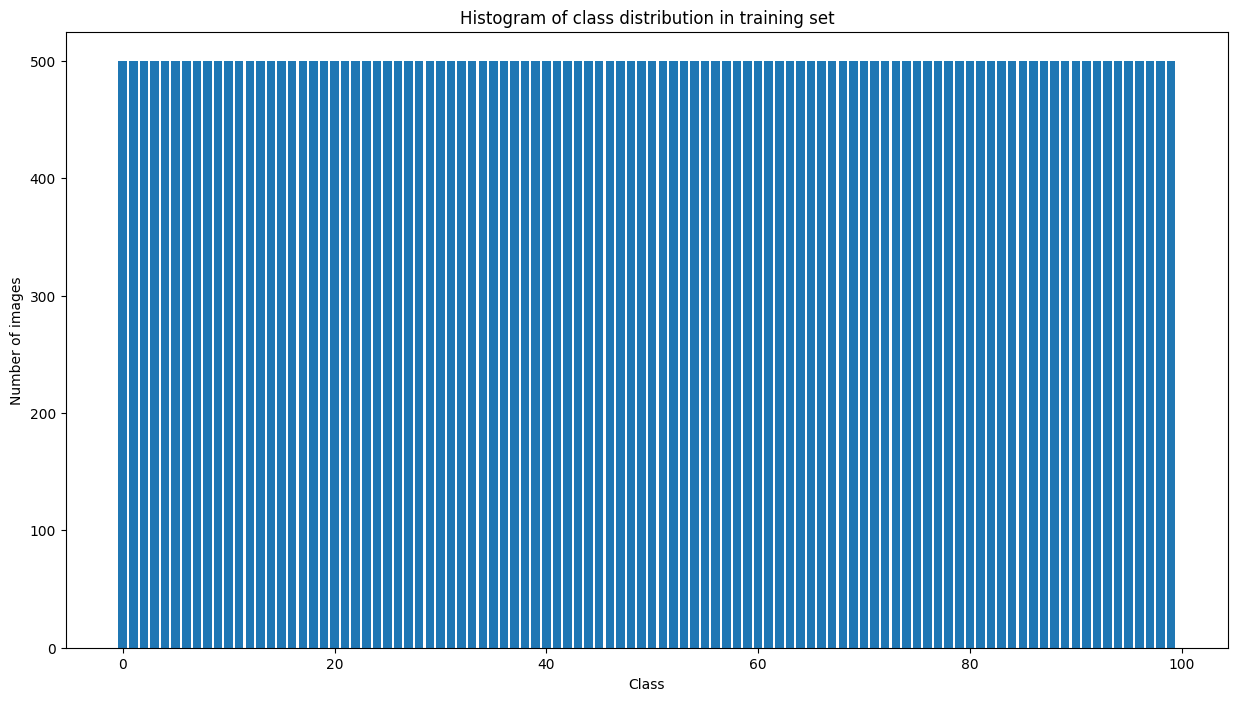

(50000, 100)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your one-hot-encoded label array is named `y_train`
class_counts = np.sum(y_train_hot_encoded, axis=0)
class_indices = np.arange(class_counts.shape[0])
plt.figure(figsize=(15, 8))
plt.bar(class_indices, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Histogram of class distribution in training set')
plt.show()

print(y_train_hot_encoded.shape)

In [ ]:
def print_matrix_2(my_vector, good, bad):

  # reshape the vector into a 10x10 matrix
  my_matrix = my_vector.reshape((10, 10))

  # print the matrix with colors
  for i in range(10):
      for j in range(10):
          if my_matrix[i, j] < good:
              # if the value is even, print it in green
              print(Fore.GREEN + f"{my_matrix[i, j]:.2f}", end=" ")
          elif my_matrix[i, j] > bad:
              # if the value is odd, print it in red
              print(Fore.RED + f"{my_matrix[i, j]:.2f}", end=" ")
          else:
              print(Fore.YELLOW + f"{my_matrix[i, j]:.2f}", end=" ")
      print(Style.RESET_ALL)  # reset the color after each row

In [ ]:
import numpy as np

# assume `probs` is an array of shape (num_instances, num_classes) containing the probabilities for each class
# assume `true_classes` is a one-hot encoded array of shape (num_instances, num_classes) containing the true classes for each instance

# find the indices of the two highest probabilities for each instance
sorted_indices = np.argsort(probs_y_test, axis=1)
top2_indices = sorted_indices[:, -2:]

# select the predicted classes based on the second highest probability
pred_classes = top2_indices[:, 0]  # take the second highest probability

# count the number of correct predictions
correct_preds = np.sum(y_test_hot_encoded[np.arange(len(y_test_hot_encoded)), pred_classes])

# compute the accuracy for each class
class_accuracies2 = np.zeros((y_test_hot_encoded.shape[1]))
for c in range(y_test_hot_encoded.shape[1]):
    # find the instances where the true class is c
    idx = np.where(y_test_hot_encoded[:, c] == 1)[0]
    # count the number of correct predictions for class c
    class_correct_preds = np.sum(pred_classes[idx] == c)
    # divide by the total number of instances for class c to get the accuracy
    if len(idx) > 0:
        class_accuracies2[c] = class_correct_preds / len(idx)

# print the accuracy for each class
print_matrix_2(class_accuracies2,0.1,0.2)


0.04 0.04 0.08 0.23 0.10 0.12 0.10 0.12 0.06 0.01 
0.12 0.29 0.05 0.11 0.07 0.06 0.02 0.06 0.09 0.06 
0.05 0.03 0.07 0.05 0.04 0.12 0.14 0.12 0.12 0.08 
0.18 0.06 0.10 0.22 0.05 0.27 0.04 0.07 0.10 0.04 
0.12 0.06 0.10 0.07 0.11 0.10 0.16 0.25 0.05 0.10 
0.28 0.05 0.23 0.04 0.07 0.09 0.04 0.05 0.01 0.17 
0.09 0.11 0.12 0.09 0.14 0.11 0.06 0.11 0.02 0.06 
0.11 0.12 0.14 0.15 0.11 0.04 0.04 0.06 0.11 0.04 
0.15 0.27 0.04 0.10 0.07 0.04 0.08 0.06 0.11 0.01 
0.04 0.05 0.18 0.07 0.00 0.05 0.19 0.00 0.23 0.11 


In [ ]:
print_matrix(class_accuracies2)

In [ ]:
import numpy as np

# assume `probs` is an array of shape (num_instances, num_classes) containing the probabilities for each class
# assume `true_classes` is a one-hot encoded array of shape (num_instances, num_classes) containing the true classes for each instance

# find the indices of the two highest probabilities for each instance
sorted_indices = np.argsort(probs_y_test, axis=1)
top3_indices = sorted_indices[:, -3:]

# select the predicted classes based on the second highest probability
pred_classes = top3_indices[:, 0]  # take the second highest probability

# count the number of correct predictions
correct_preds = np.sum(y_test_hot_encoded[np.arange(len(y_test_hot_encoded)), pred_classes])

# compute the accuracy for each class
class_accuracies = np.zeros((y_test_hot_encoded.shape[1]))
for c in range(y_test_hot_encoded.shape[1]):
    # find the instances where the true class is c
    idx = np.where(y_test_hot_encoded[:, c] == 1)[0]
    # count the number of correct predictions for class c
    class_correct_preds = np.sum(pred_classes[idx] == c)
    # divide by the total number of instances for class c to get the accuracy
    if len(idx) > 0:
        class_accuracies[c] = class_correct_preds / len(idx)

# print the accuracy for each class
print(class_accuracies)

[0.         0.01282051 0.02564103 0.12987013 0.09090909 0.05128205
 0.02439024 0.0375     0.         0.03947368 0.075      0.19736842
 0.02531646 0.01234568 0.0625     0.01162791 0.01234568 0.
 0.07058824 0.02380952 0.02325581 0.         0.01333333 0.01315789
 0.0617284  0.02631579 0.04761905 0.02469136 0.01136364 0.01265823
 0.07792208 0.04166667 0.12987013 0.09638554 0.0125     0.18072289
 0.01265823 0.02469136 0.02777778 0.02469136 0.         0.01219512
 0.06329114 0.02352941 0.0617284  0.         0.06493506 0.06493506
 0.02325581 0.01190476 0.0125     0.01315789 0.07692308 0.02352941
 0.06976744 0.04       0.03658537 0.03571429 0.01282051 0.11538462
 0.03846154 0.03658537 0.04938272 0.01219512 0.07594937 0.03614458
 0.         0.02777778 0.01204819 0.01190476 0.10126582 0.05263158
 0.06976744 0.05952381 0.02531646 0.01204819 0.01265823 0.06024096
 0.02439024 0.03614458 0.05128205 0.02439024 0.01234568 0.05063291
 0.06024096 0.0125     0.05813953 0.03529412 0.01333333 0.01234568
 0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def ModelCalibration_plot(y_prob, y_true, y_prob_2):
    # y_true: true labels, y_prob: predicted probabilities
    n_bins = 50  # number of bins
    bin_size = 1 / n_bins  # size of each bin

    bins = np.linspace(0, 1, n_bins+1)  # define the bin edges
    bin_centers = np.linspace(bin_size/2, 1-bin_size/2, n_bins)  # define the bin centers

    # Compute the mean predicted probability and the true frequency for each bin
    mean_predicted_value = []
    fraction_of_positives = []
    counts = []
    mean_predicted_value_2 = []
    fraction_of_positives_2 = []
    counts_2 = []

    for bin_start, bin_end in zip(bins[:-1], bins[1:]):
        idx = (y_prob >= bin_start) & (y_prob < bin_end)  # indices of the examples in the current bin
        idx_2 = (y_prob_2 >= bin_start) & (y_prob_2 < bin_end)  # indices of the examples in the current bin
        result = [y_prob[i] for i in range(len(y_prob)) if idx[i]]
        result_2 = [y_prob_2[i] for i in range(len(y_prob_2)) if idx_2[i]]
        true = [y_true[i] for i in range(len(y_prob)) if idx[i]]
        true_2 = [y_true[i] for i in range(len(y_prob_2)) if idx_2[i]]

        if np.sum(idx) == 0:  # if there are no examples in the bin, skip it
            continue
        mean_predicted_value.append(np.mean(result))          # mean predicted probability for the current bin
        fraction_of_positives.append(np.sum(true)/np.sum(idx))      # true frequency for the current bin
        counts.append(np.sum(idx))  # number of points in the current bin
        if np.sum(idx_2) == 0:  # if there are no examples in the bin, skip it
            continue
        mean_predicted_value_2.append(np.mean(result_2))          # mean predicted probability for the current bin
        fraction_of_positives_2.append(np.sum(true_2)/np.sum(idx_2))      # true frequency for the current bin
        counts_2.append(np.sum(idx_2))  # number of points in the current bin
    print("TS")
    print(counts)
    print("Baseline")
    print(counts_2)

    # Plot the reliability diagram
    fig, ax = plt.subplots()
    img = ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    sc = ax.scatter(mean_predicted_value, fraction_of_positives, c=counts, cmap='viridis', marker='o', label='TS')
    sc2 = ax.scatter(mean_predicted_value_2, fraction_of_positives_2, marker='d', c=counts_2, cmap='magma' , label='baseline')
    cbar = fig.colorbar(sc, label='Counts_temp')
    cbar2 = fig.colorbar(sc2, label='Counts_baseline')
    ax.set_xlabel('Mean predicted value')
    ax.set_ylabel('Fraction of positives')
    ax.set_title('Calibration Check')
    plt.legend()
    plt.show()



In [ ]:
print(y_test_hot_encoded.shape)

(8000, 100)


8000
8000
[0.8451353, 0.3854661, 0.9945633, 0.5158875, 0.43770346, 0.30555478, 0.9999838, 0.9972379, 0.31152096, 0.6954709, 0.82166797, 0.9998734, 0.85484684, 0.99999, 0.9857356, 0.99984264, 0.79222125, 0.78275096, 0.5670538, 0.9986504, 0.9696408, 0.9920237, 0.81720406, 0.96551883, 0.9998109, 0.8694109, 0.26745185, 0.9944405, 0.42522088, 0.44481048, 0.9642078, 0.8545396, 0.87299824, 0.9977938, 0.6871411, 0.93822104, 0.9276547, 0.99433446, 0.99165714, 0.9982387, 0.93070924, 0.4600305, 0.9220193, 0.9992778, 0.7890655, 0.9858527, 0.98656285, 0.7198195, 0.8699996, 0.92728966, 0.6980494, 0.99876404, 0.9850728, 0.2800232, 0.9817062, 0.9990362, 0.99985504, 0.46478325, 0.2203446, 0.99995637, 0.8015272, 0.54023683, 0.94518214, 0.78880763, 0.57987297, 0.9874161, 0.9992976, 0.95625615, 0.9079945, 0.9189721, 0.87729895, 0.9009636, 0.9999826, 0.9997093, 0.9999924, 0.16914047, 0.4135524, 0.9770234, 0.969828, 0.96678156, 0.9992874, 0.86190045, 0.99416876, 0.75747234, 0.9010158, 0.19603579, 0.41448808

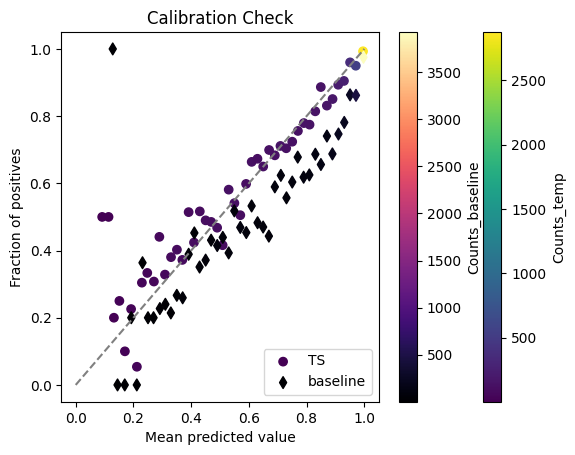

In [ ]:
#print(probs_temp_y_test_copy)
x_first_position=[]
y_first_position=[]
y_probs_first_position=[]
x_probs_first_position=[]
print(len(probs_temp_y_test_copy))
for i in range(len(probs_temp_y_test_copy)):
  x_first_position.append(np.max(probs_temp_y_test_copy[i]))
  x_probs_first_position.append(np.max(probs_y_test_copy[i]))
  j=np.argmax(probs_temp_y_test_copy[i])
  j2=np.argmax(probs_y_test_copy[i])
  y_first_position.append(y_test_hot_encoded_copy[i,j])
  y_probs_first_position.append(y_test_hot_encoded_copy[i,j2])


print(len(x_first_position))
print(x_first_position)

print(y_first_position)

#probs_array_1, y_test_array_1 = pre_calibration(x_first_position, y_first_position)
ModelCalibration_plot(x_first_position, y_first_position, x_probs_first_position)

[2, 2, 10, 16, 20, 31, 37, 46, 42, 52, 59, 67, 71, 82, 86, 70, 92, 91, 98, 101, 109, 101, 117, 122, 97, 112, 119, 104, 120, 123, 120, 142, 115, 134, 127, 145, 142, 140, 141, 160, 181, 225, 252, 350, 540, 2873]
[1, 1, 2, 5, 10, 11, 15, 15, 22, 25, 28, 45, 54, 54, 42, 57, 70, 65, 94, 82, 84, 83, 96, 86, 92, 87, 83, 70, 95, 93, 88, 106, 118, 110, 120, 134, 125, 135, 176, 229, 224, 256, 456, 3926]


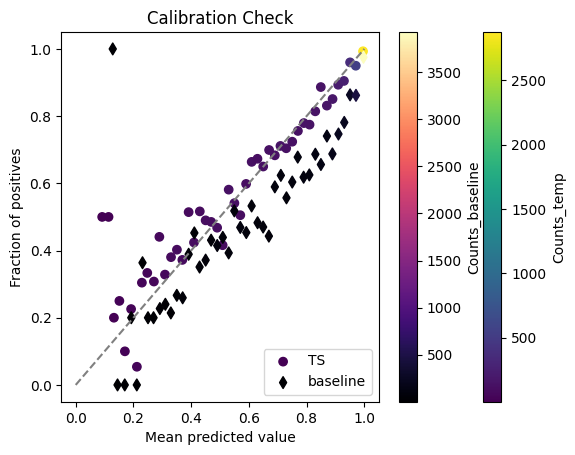


[3398, 607, 432, 353, 313, 302, 314, 260, 266, 223, 246, 174, 183, 181, 166, 117, 98, 86, 87, 62, 44, 39, 30, 15, 4]
[4443, 482, 324, 280, 247, 209, 165, 170, 183, 169, 167, 162, 151, 137, 131, 91, 100, 92, 61, 64, 47, 49, 42, 24, 10]


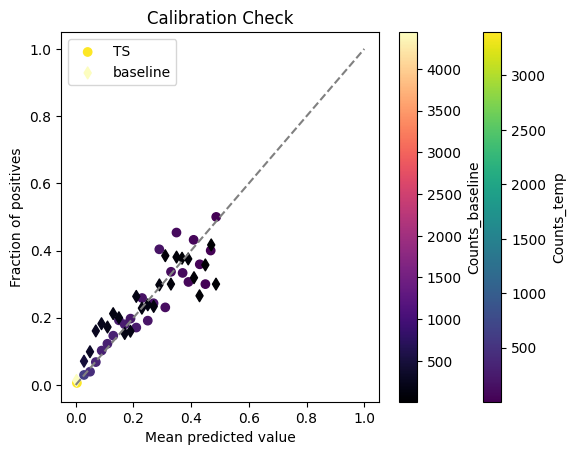


[4848, 803, 543, 452, 361, 310, 261, 142, 101, 75, 42, 25, 22, 8, 5, 2]
[6004, 533, 333, 285, 214, 163, 140, 109, 72, 48, 36, 29, 19, 9, 5, 1]


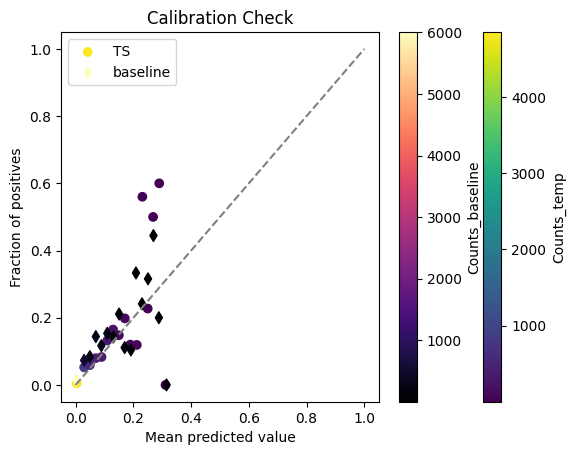


[5898, 787, 522, 374, 221, 120, 51, 19, 7, 1]
[6867, 450, 268, 177, 103, 72, 40, 18, 2, 2]


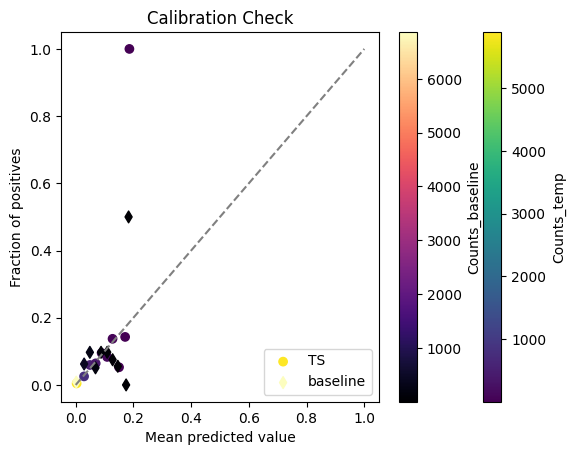


[6626, 694, 393, 207, 62, 15, 3]
[7335, 361, 167, 89, 35, 12, 1]


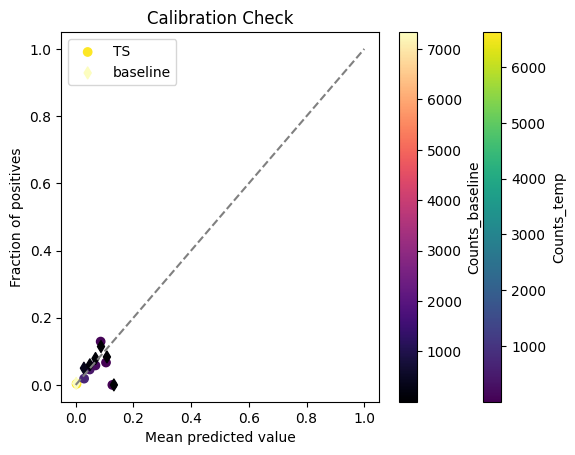


[7046, 630, 244, 72, 8]
[7594, 274, 99, 28, 5]


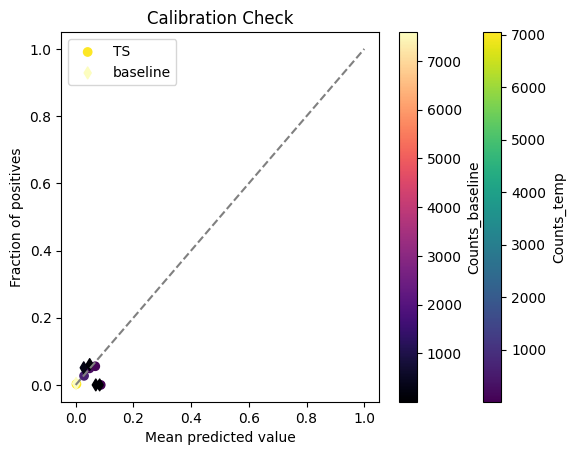


[7314, 549, 122, 15]
[7767, 182, 44, 7]


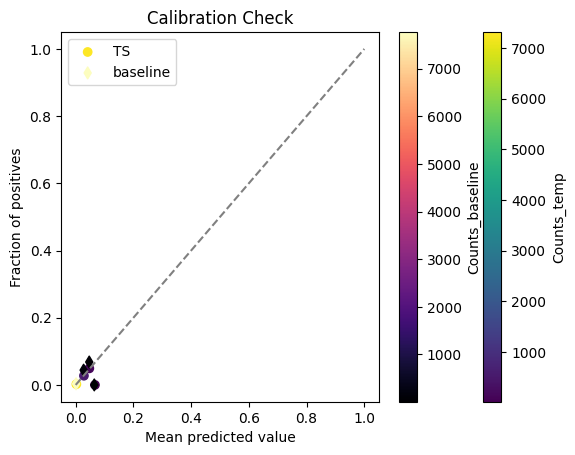


[7522, 431, 45, 2]
[7878, 107, 14, 1]


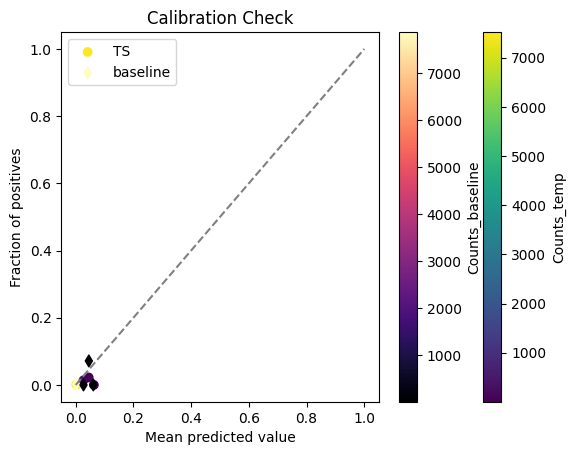


[7702, 283, 15]
[7929, 66, 5]


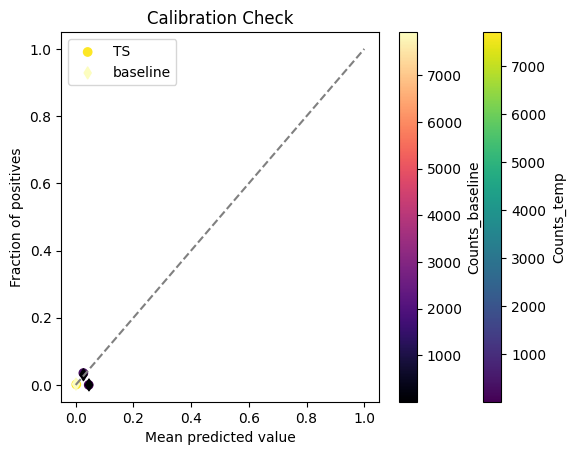


[7810, 189, 1]
[7960, 40]


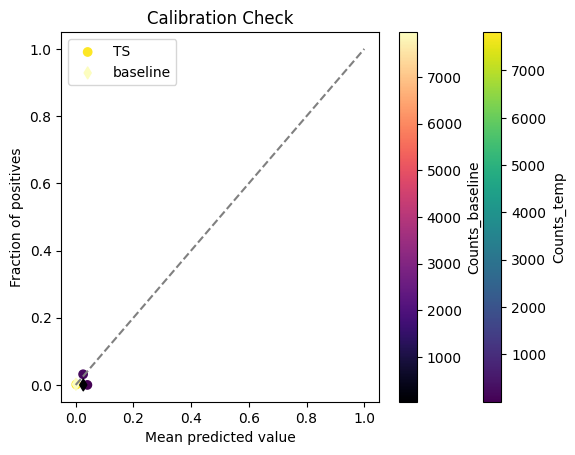


[7889, 111]
[7980, 20]


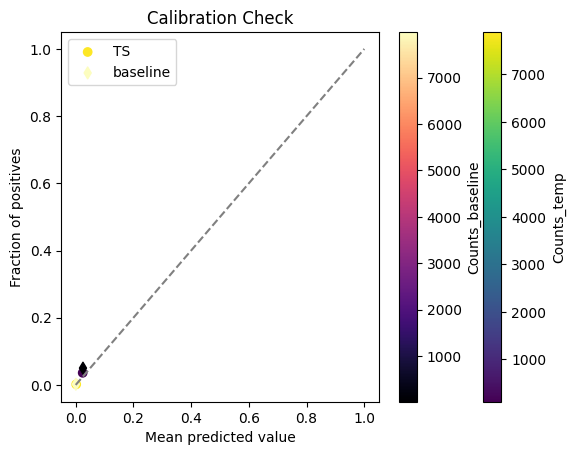


[7941, 59]
[7990, 10]


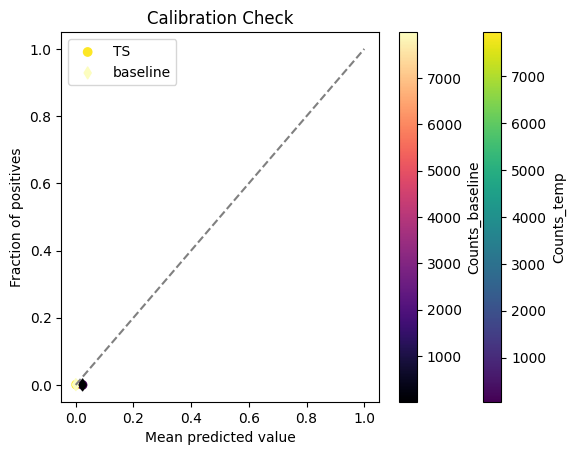


[7964, 36]
[7995, 5]


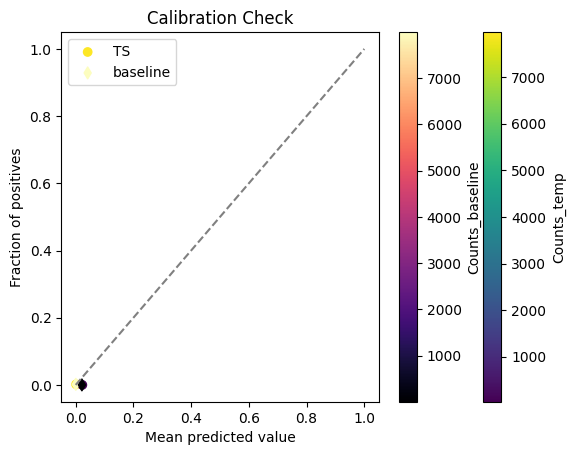


[7985, 15]
[7998, 2]


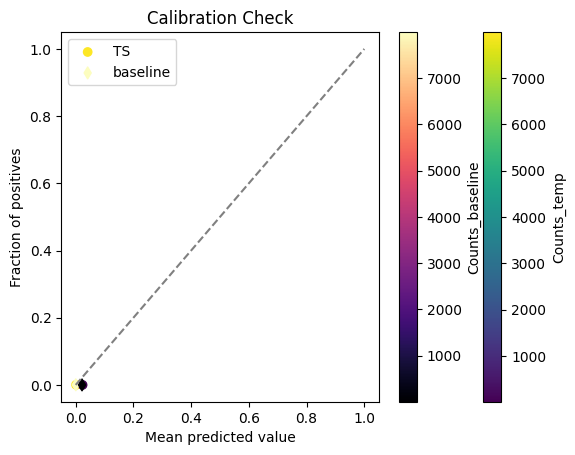


[7989, 11]
[8000]


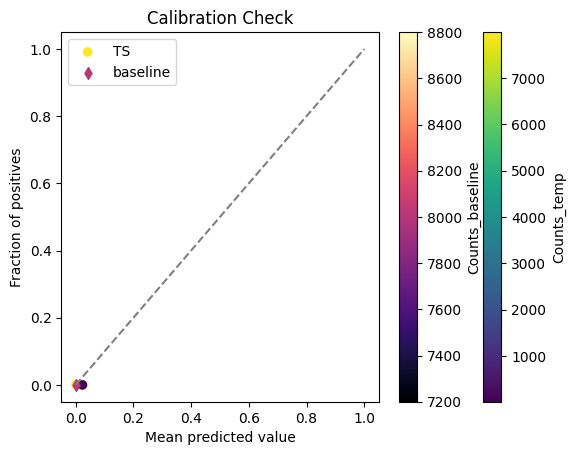


[7996, 4]
[8000]


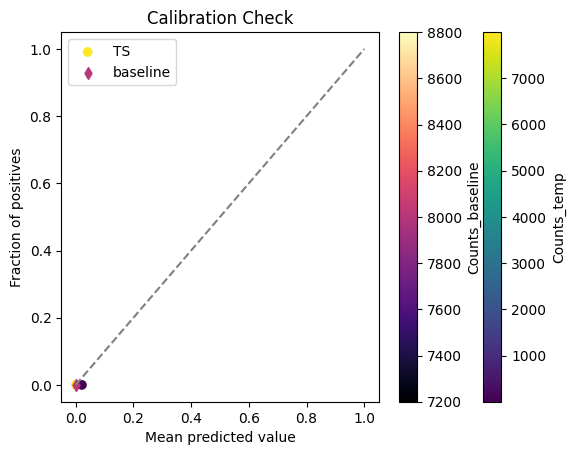


[7999, 1]
[8000]


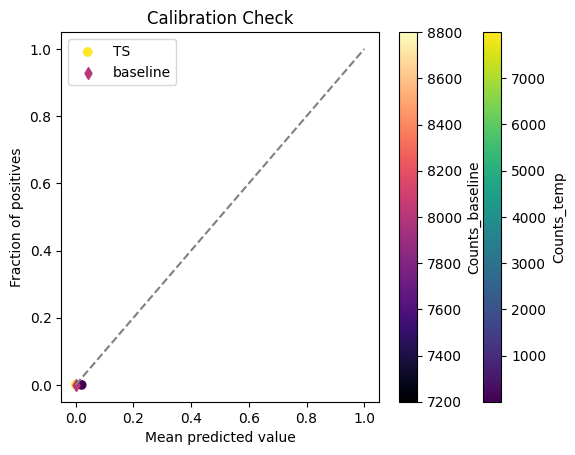


[8000]
[8000]


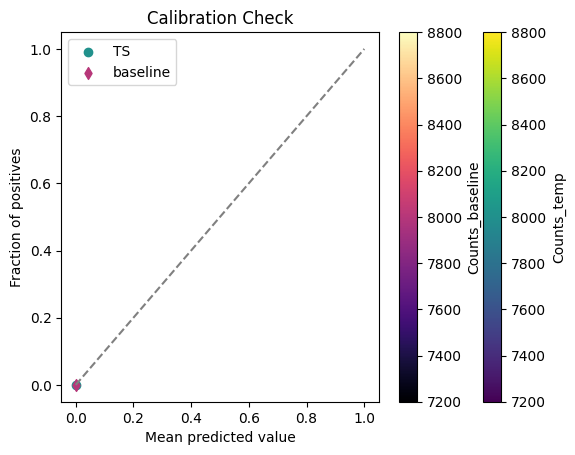


[8000]
[8000]


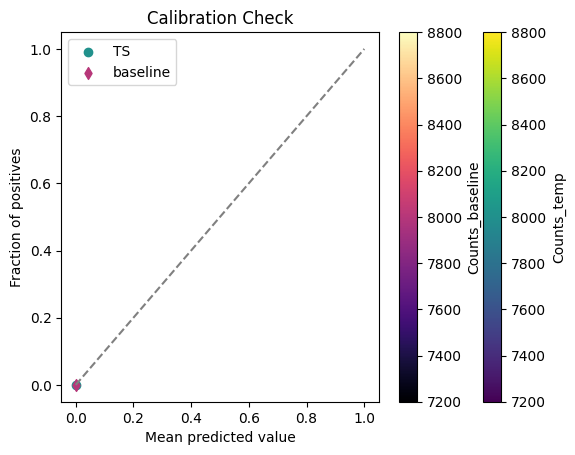


[8000]
[8000]


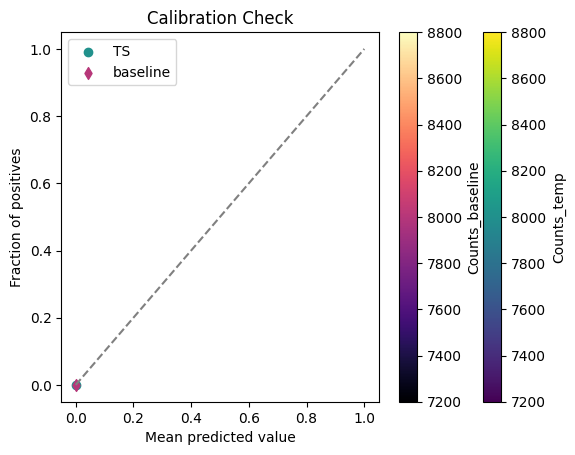


[8000]
[8000]


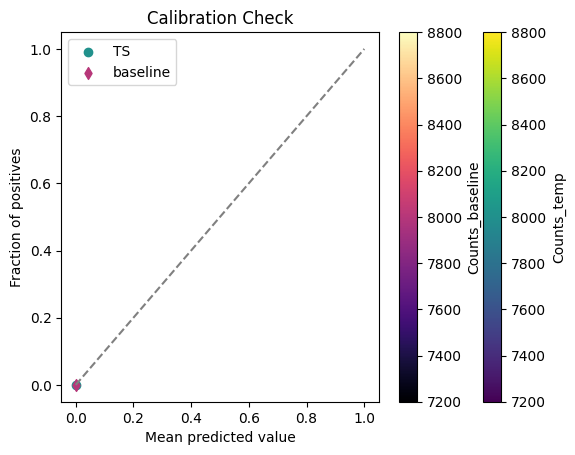


[8000]
[8000]


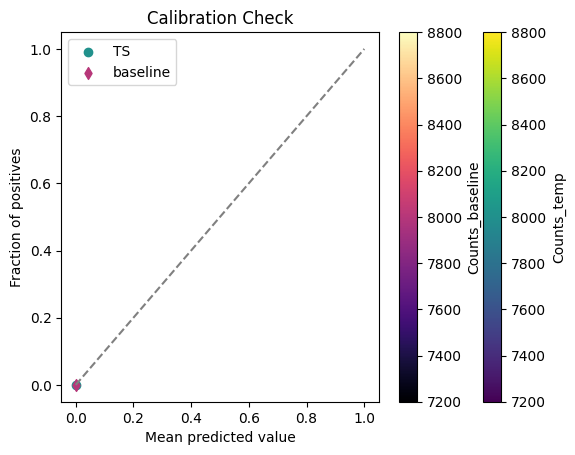


[8000]
[8000]


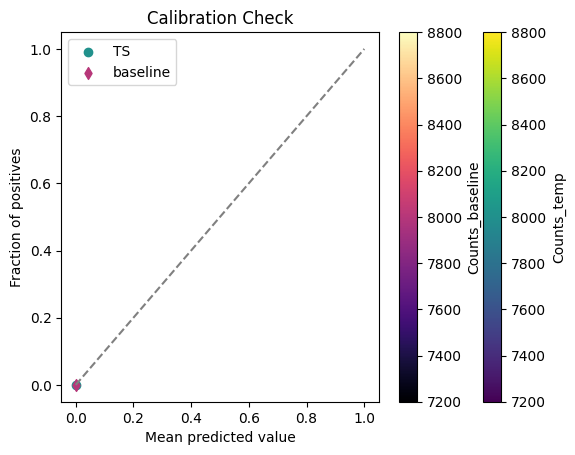


[8000]
[8000]


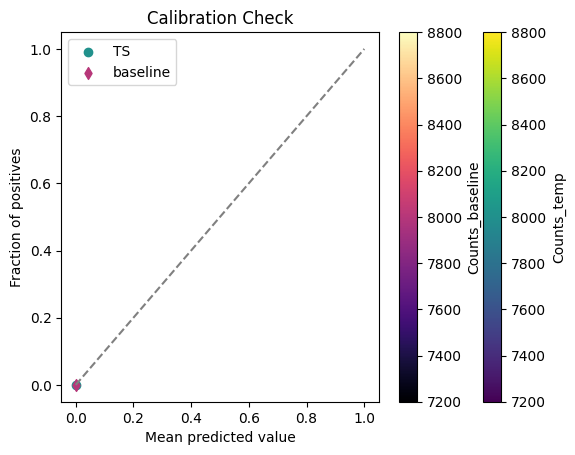


[8000]
[8000]


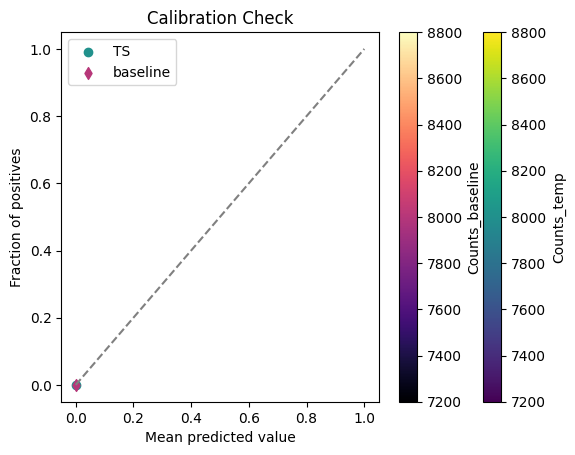


[8000]
[8000]


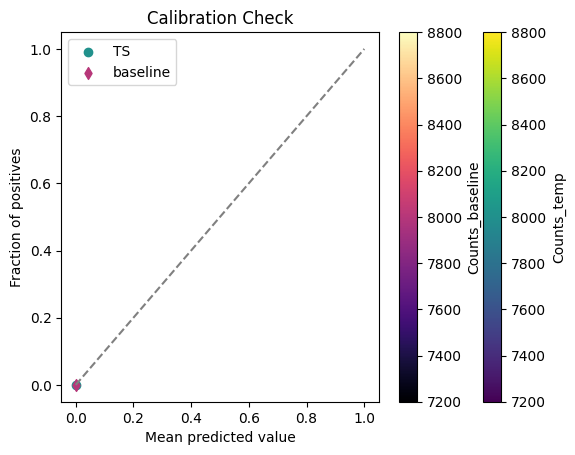


[8000]
[8000]


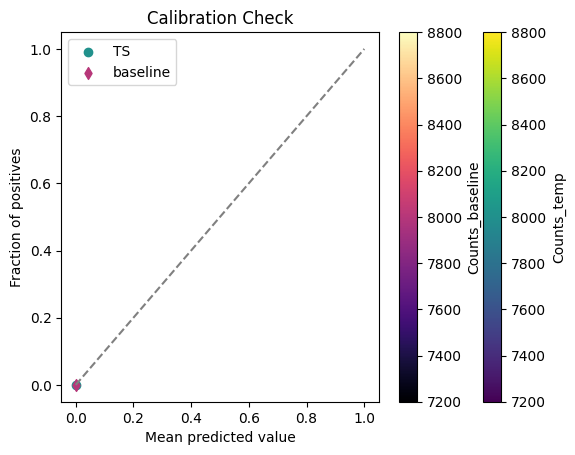


[8000]
[8000]


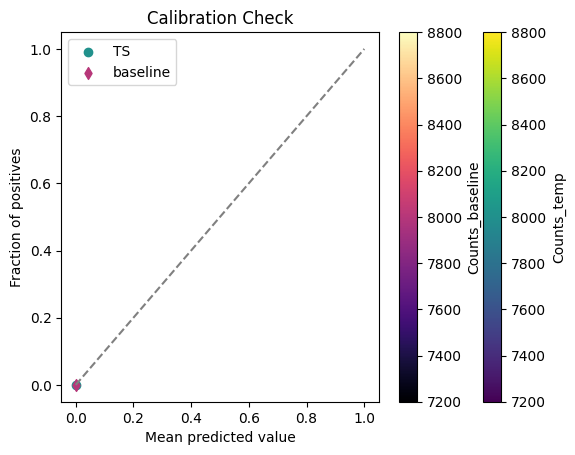


[8000]
[8000]


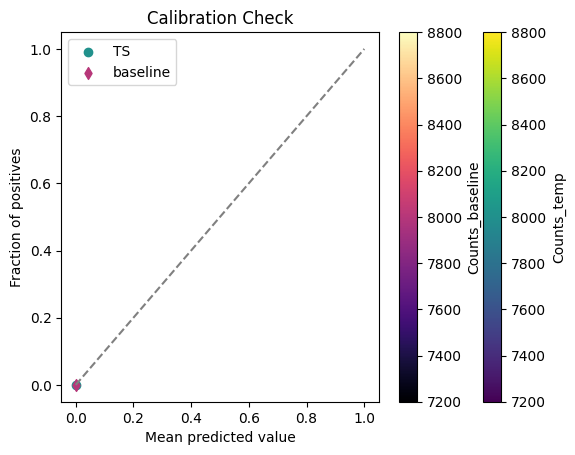


[8000]
[8000]


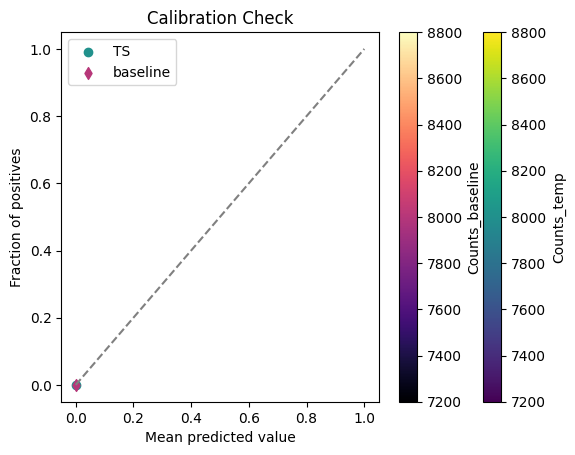


[8000]
[8000]


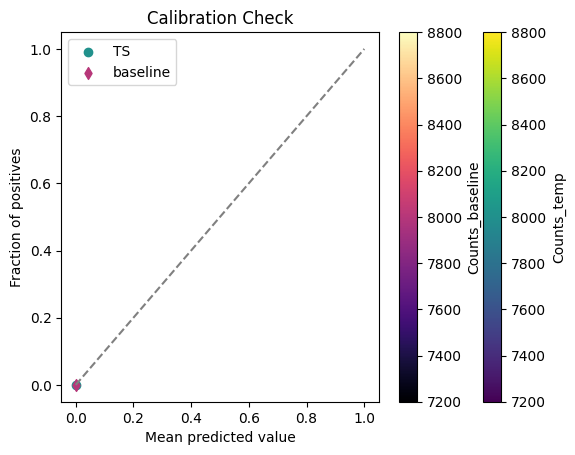


[8000]
[8000]


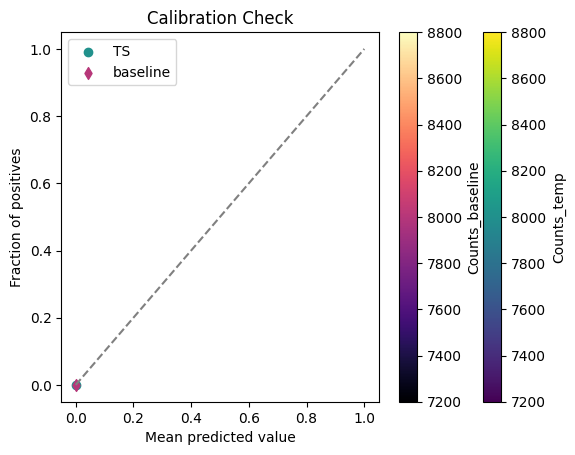


[8000]
[8000]


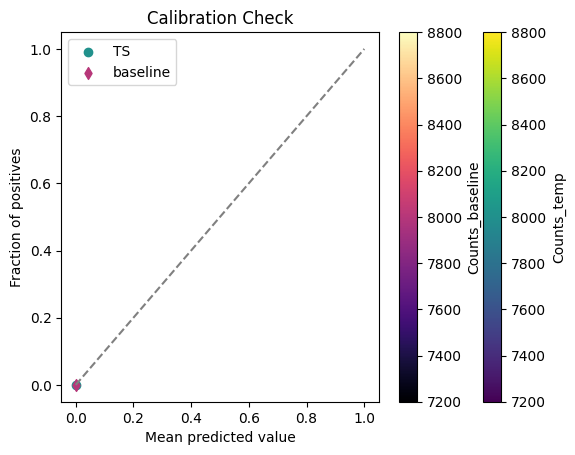


[8000]
[8000]


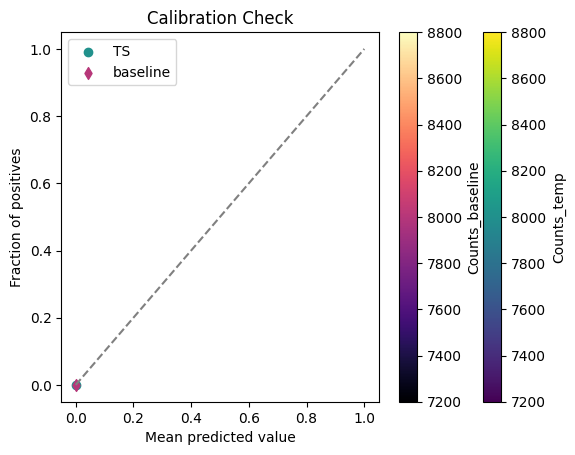


[8000]
[8000]


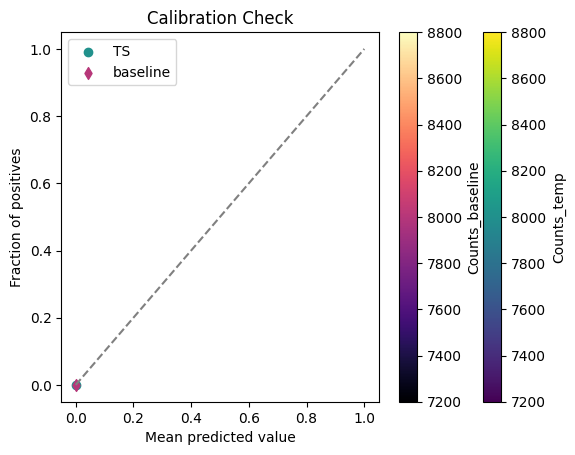


[8000]
[8000]


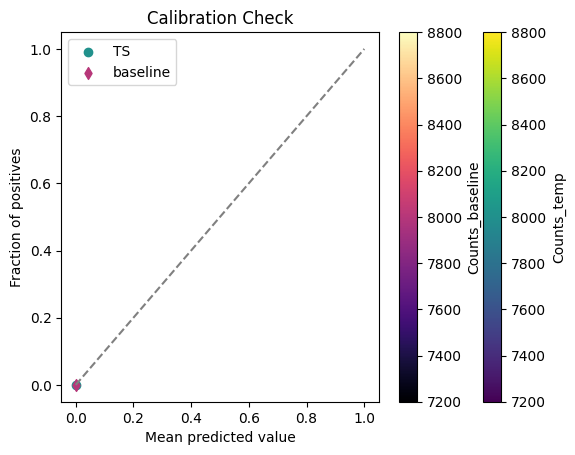


[8000]
[8000]


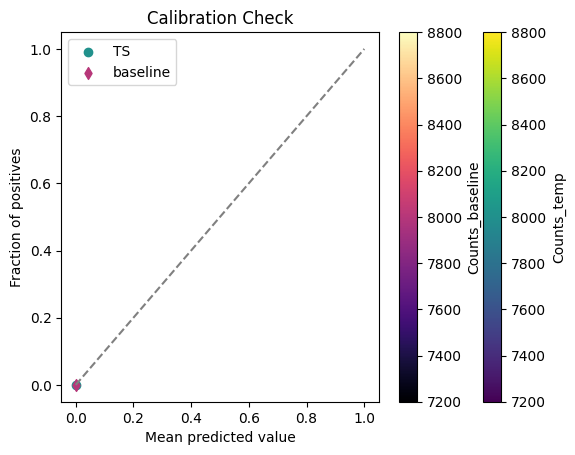


[8000]
[8000]


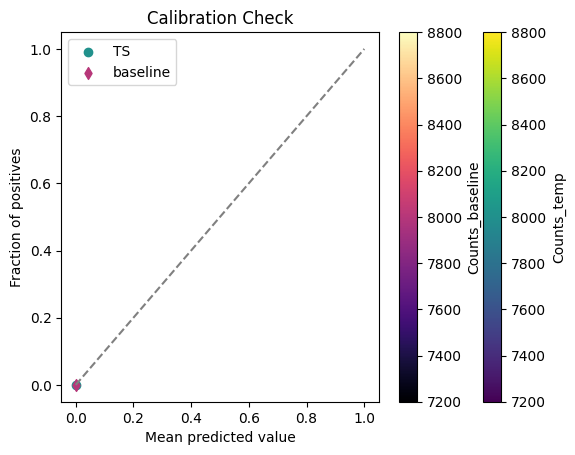


[8000]
[8000]


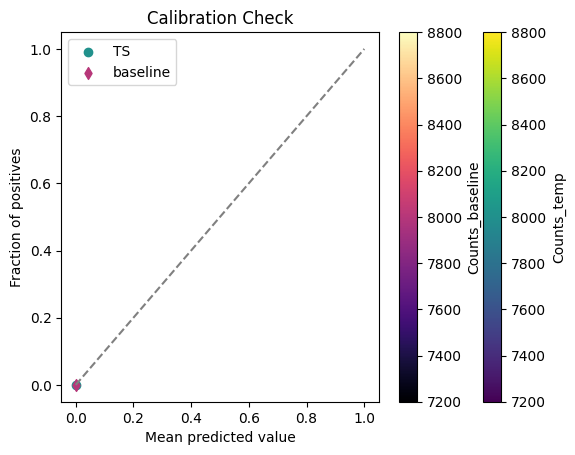


[8000]
[8000]


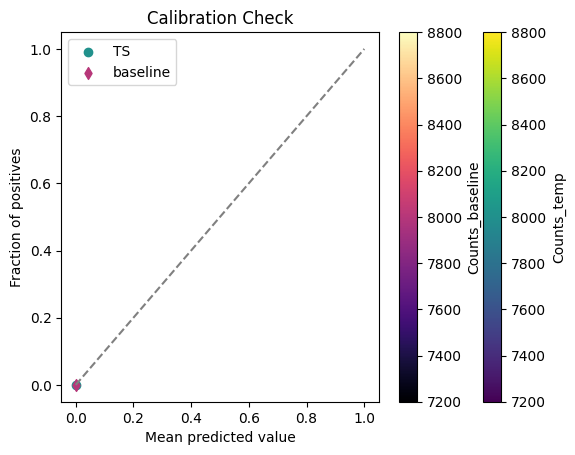


[8000]
[8000]


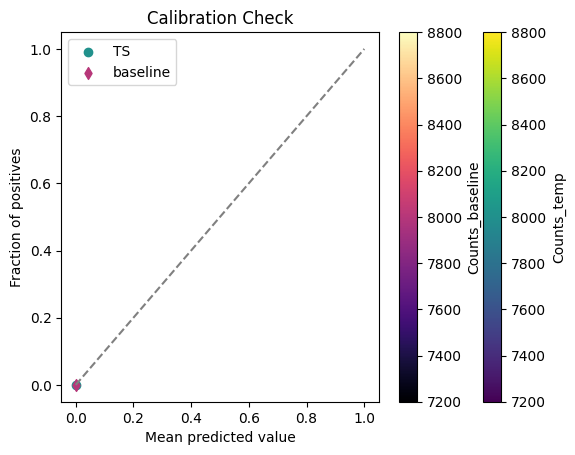


[8000]
[8000]


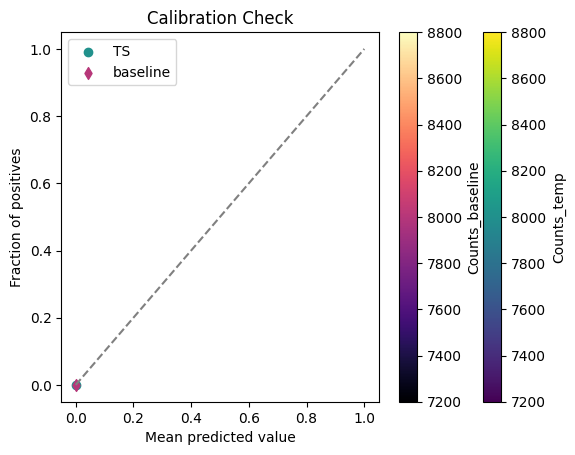


[8000]
[8000]


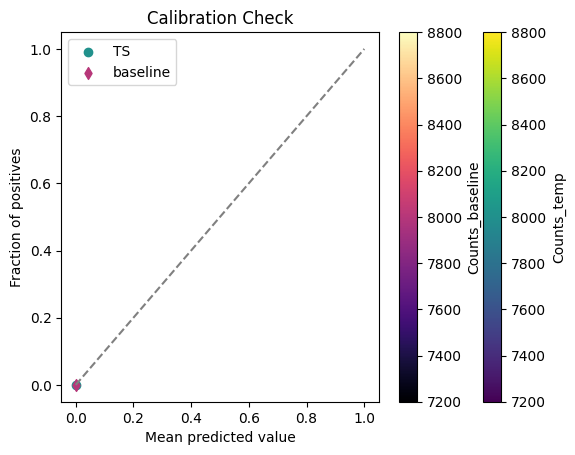


[8000]
[8000]


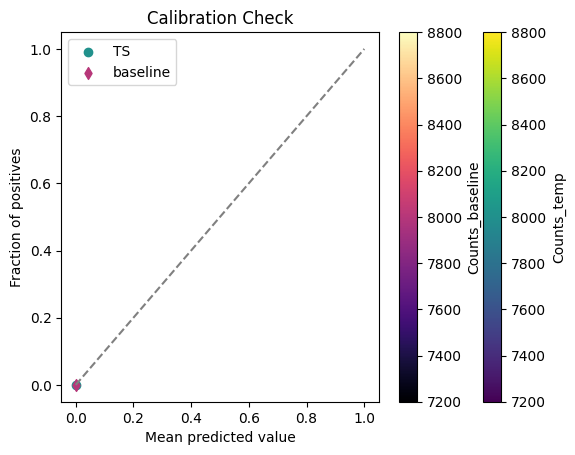


[8000]
[8000]


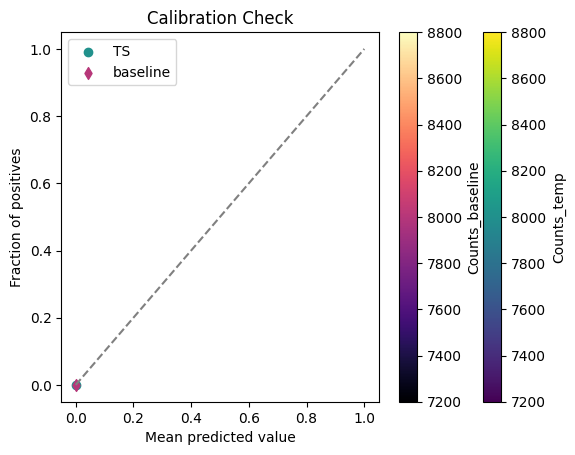


[8000]
[8000]


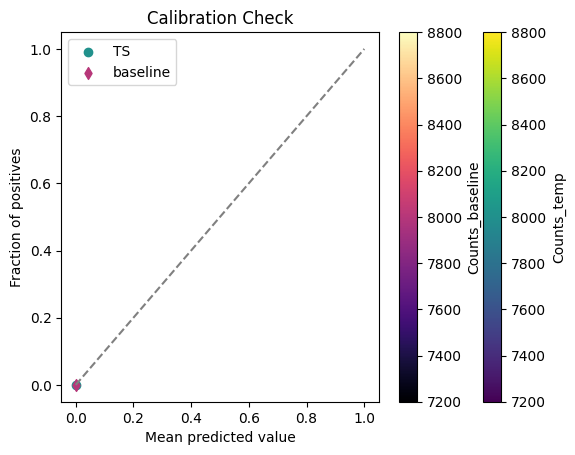


[8000]
[8000]


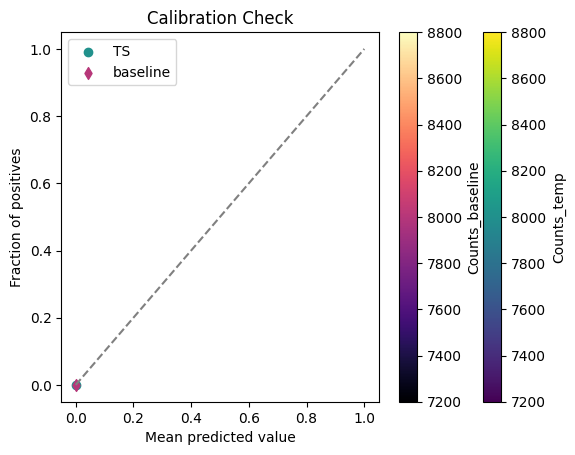


[8000]
[8000]


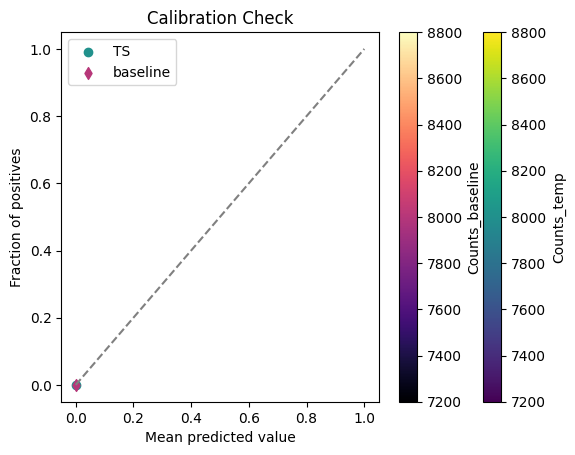


[8000]
[8000]


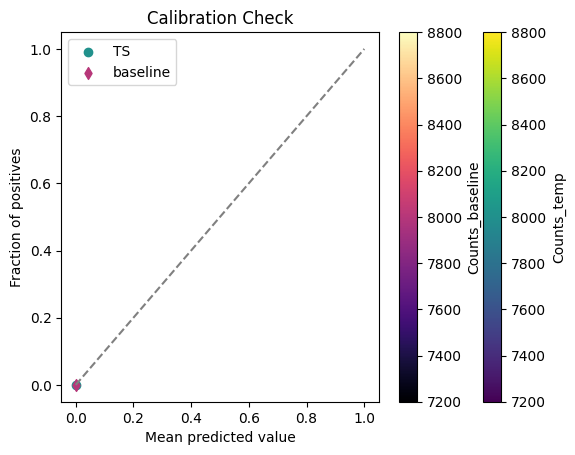


[8000]
[8000]


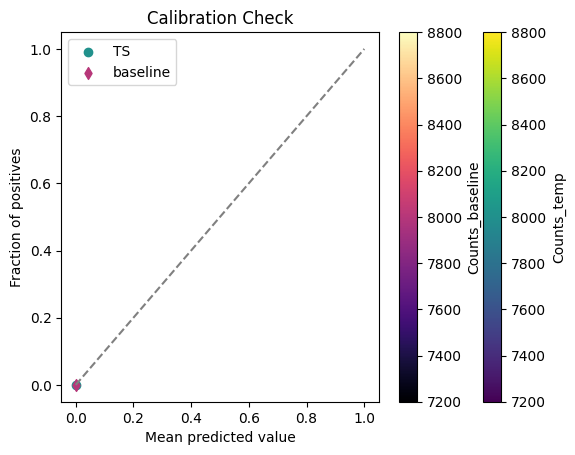


[8000]
[8000]


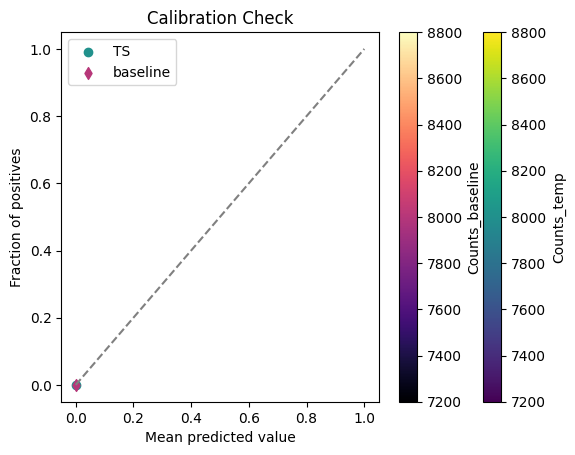


[8000]
[8000]


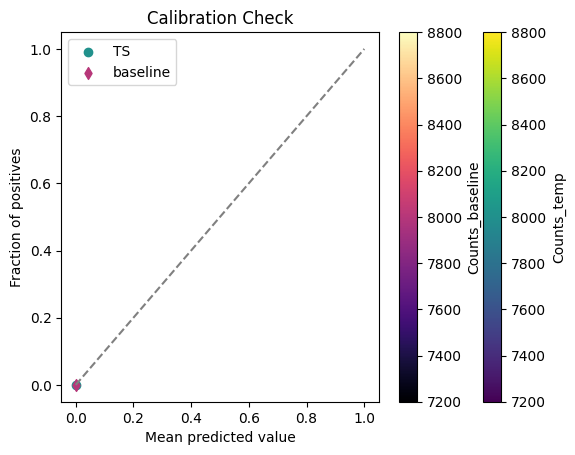


[8000]
[8000]


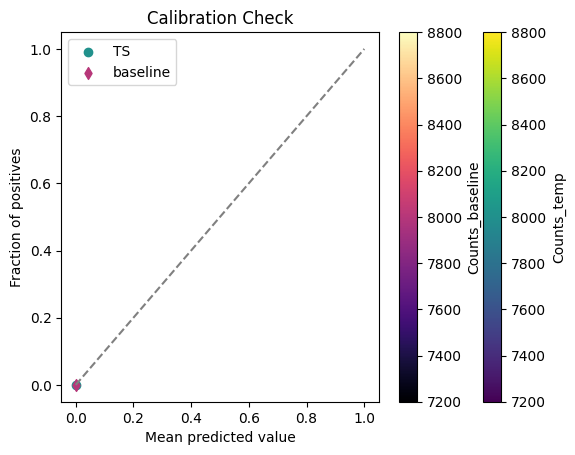


[8000]
[8000]


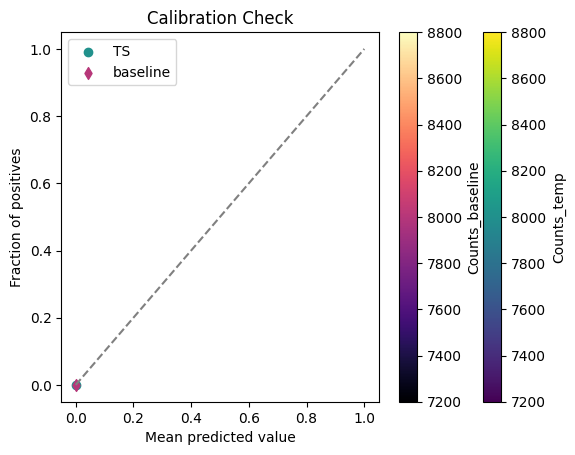


[8000]
[8000]


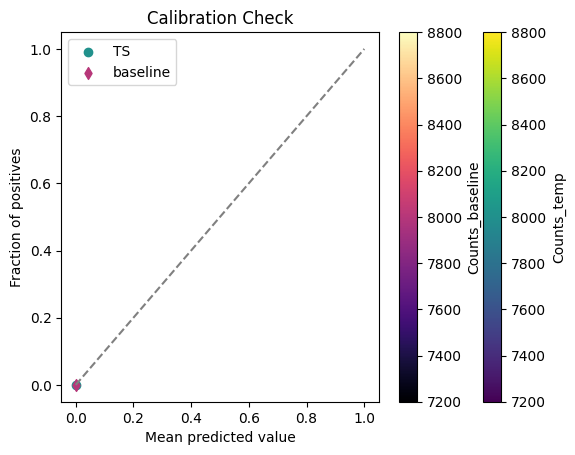


[8000]
[8000]


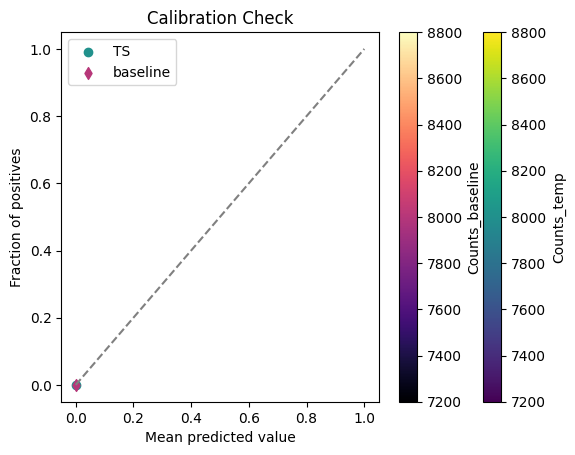


[8000]
[8000]


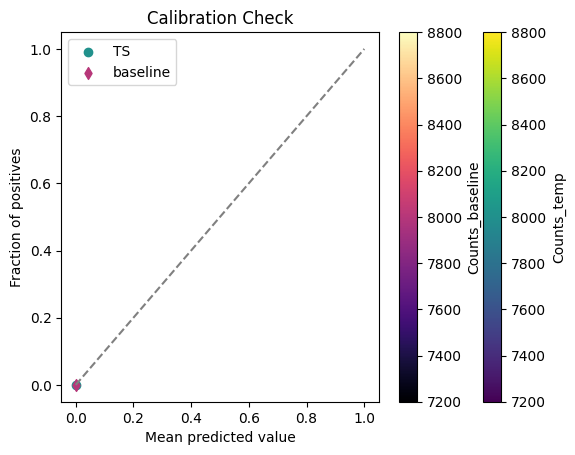


[8000]
[8000]


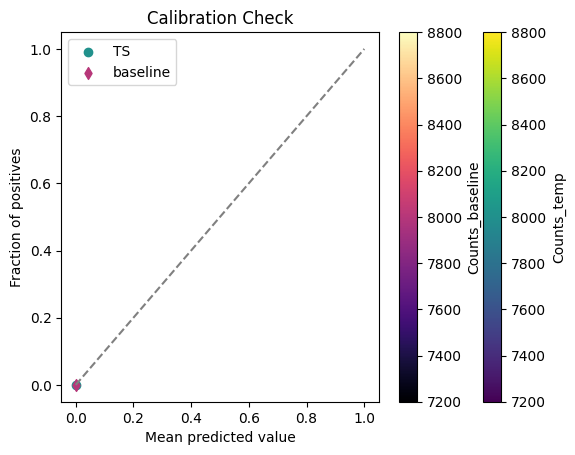


[8000]
[8000]


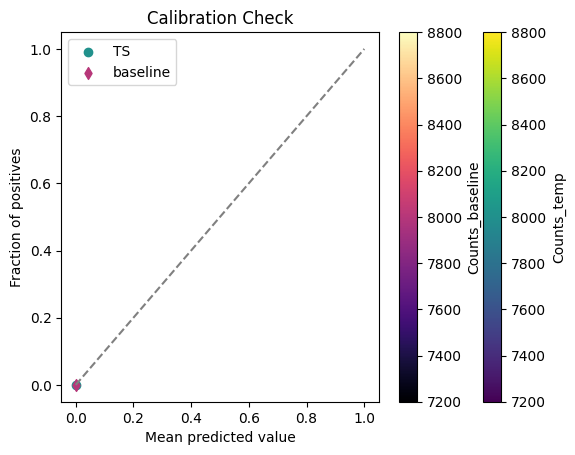


[8000]
[8000]


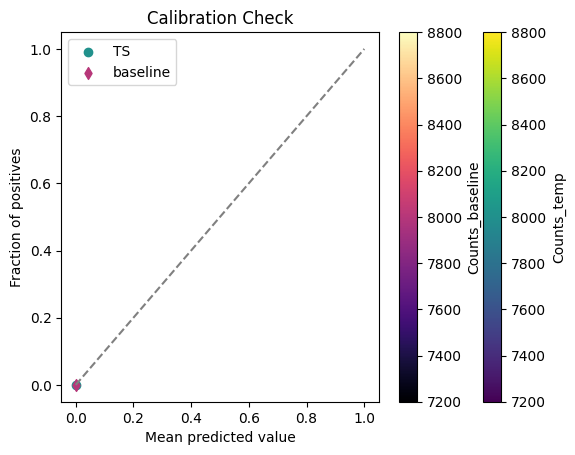


[8000]
[8000]


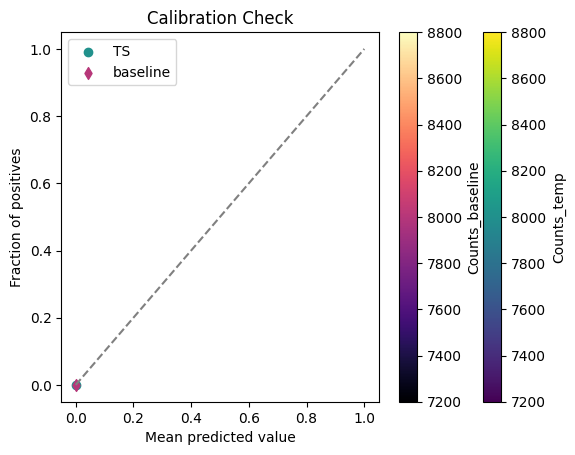


[8000]
[8000]


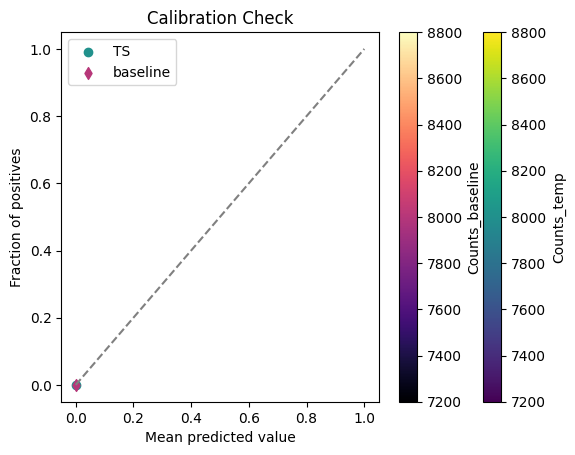


[8000]
[8000]


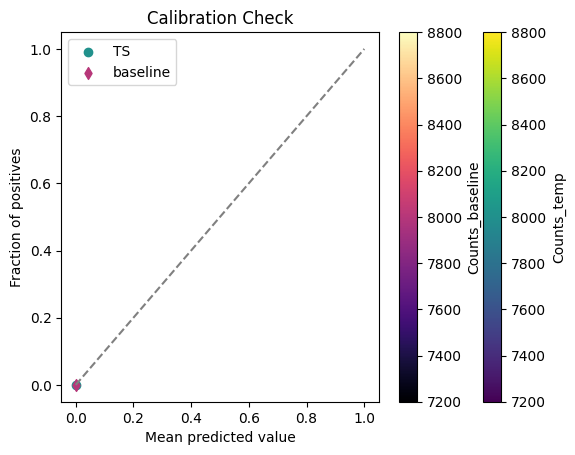


[8000]
[8000]


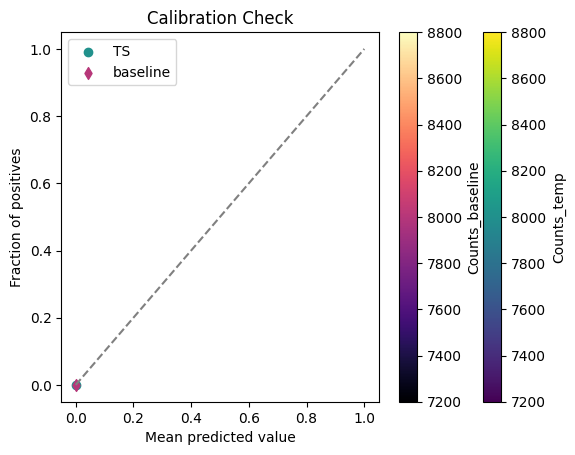


[8000]
[8000]


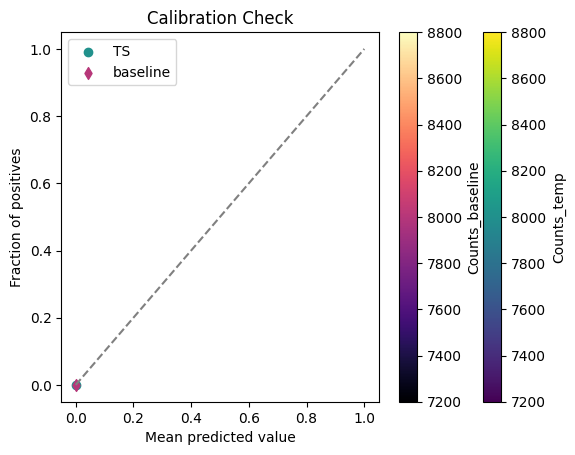


[8000]
[8000]


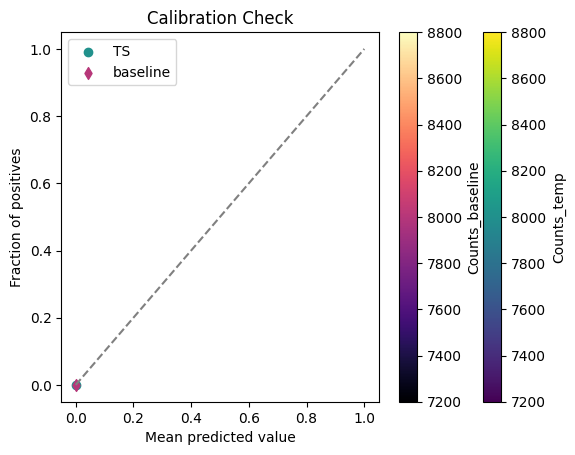


[8000]
[8000]


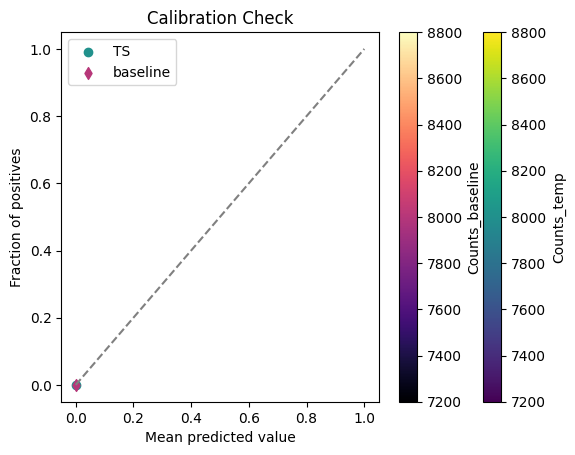


[8000]
[8000]


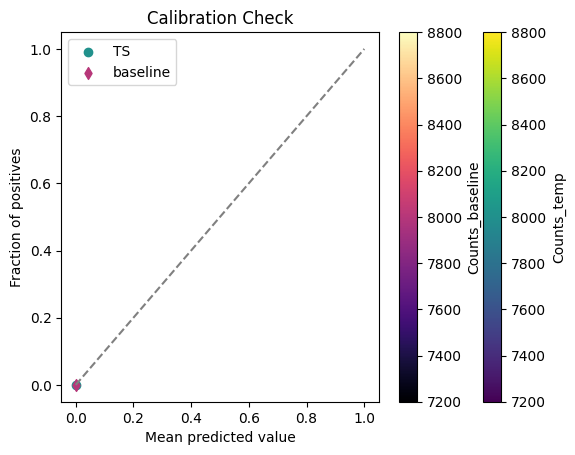


[8000]
[8000]


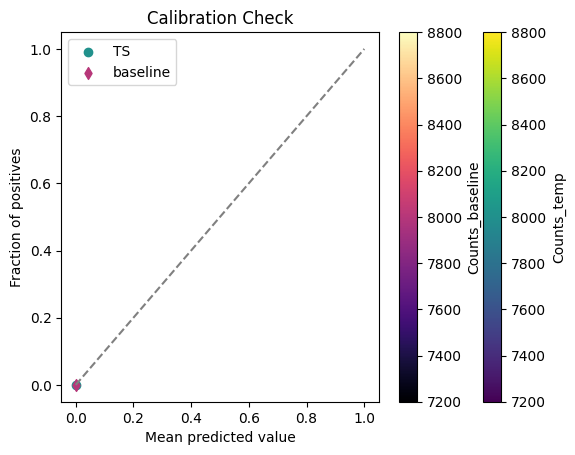


[8000]
[8000]


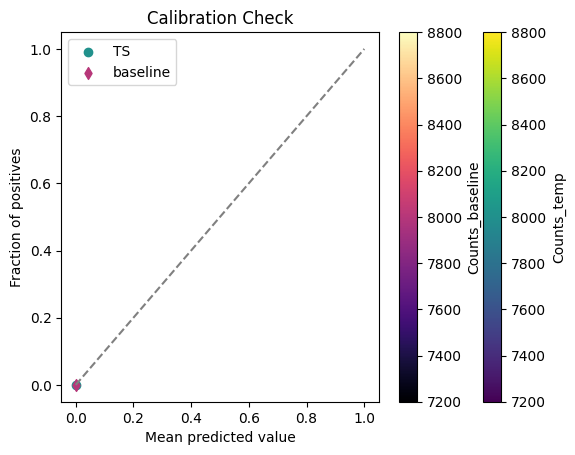


[8000]
[8000]


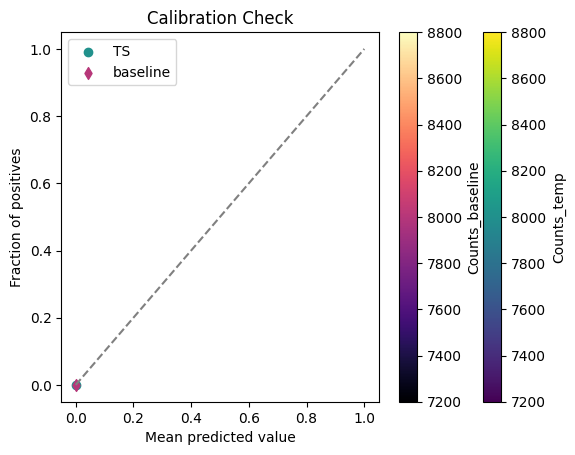


[8000]
[8000]


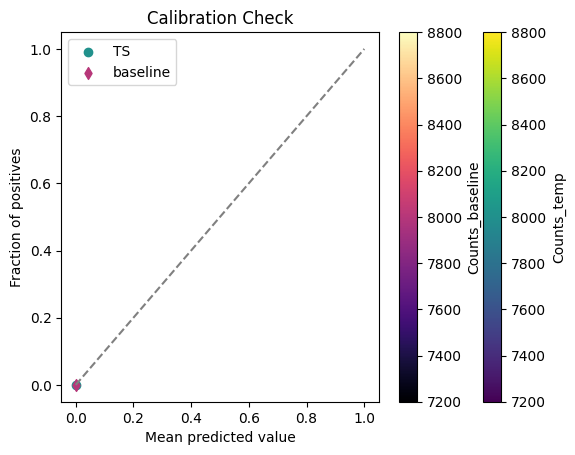


[8000]
[8000]


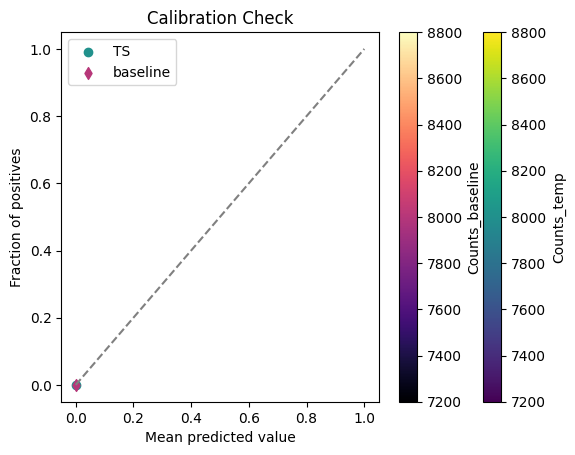


[8000]
[8000]


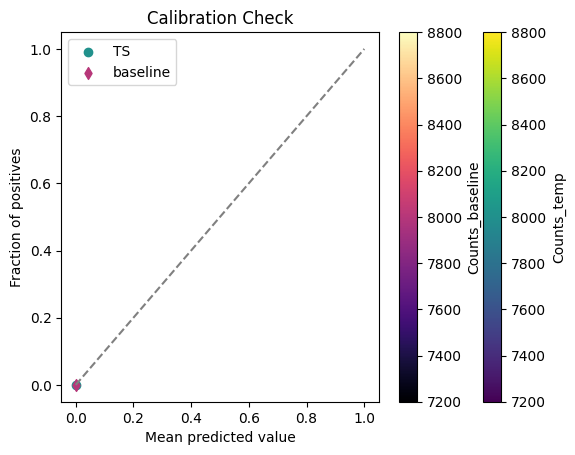


[8000]
[8000]


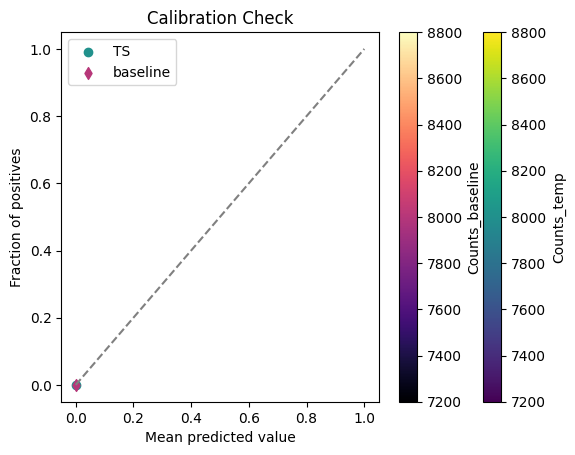


[8000]
[8000]


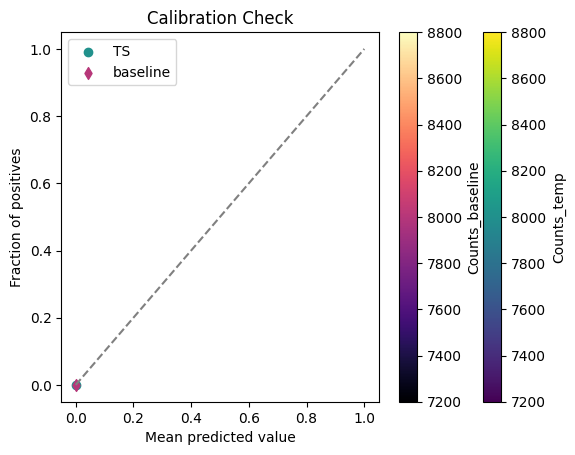


[8000]
[8000]


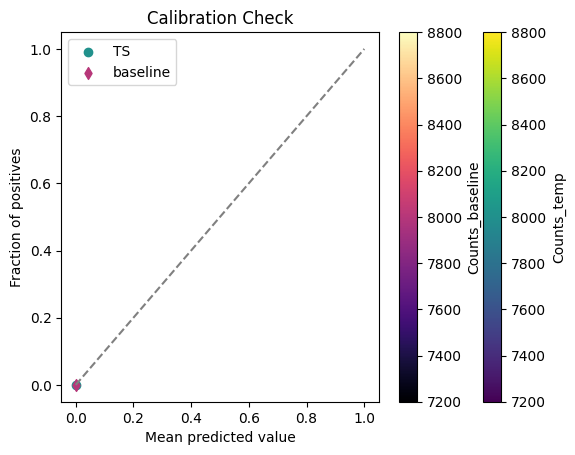


[8000]
[8000]


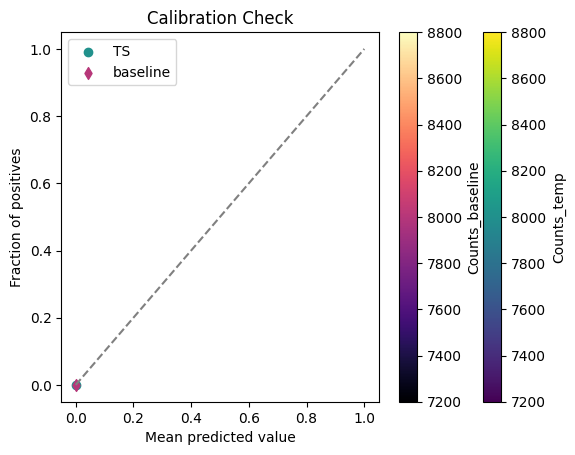


[8000]
[8000]


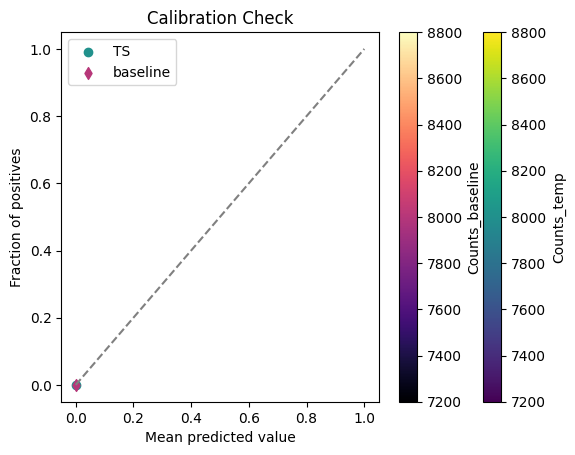


[8000]
[8000]


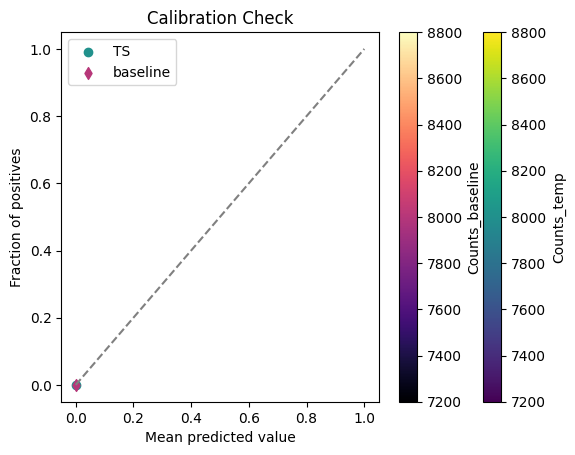


[8000]
[8000]


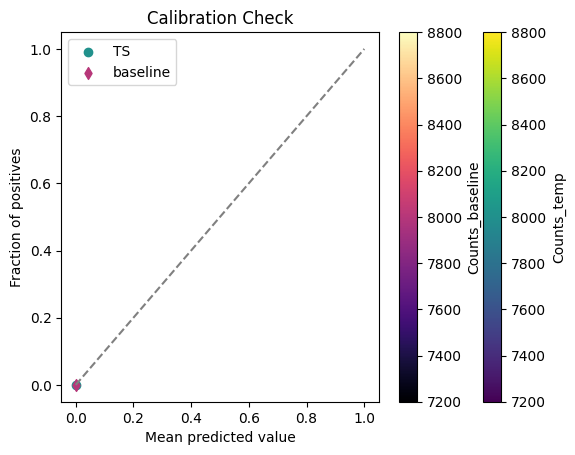


[8000]
[8000]


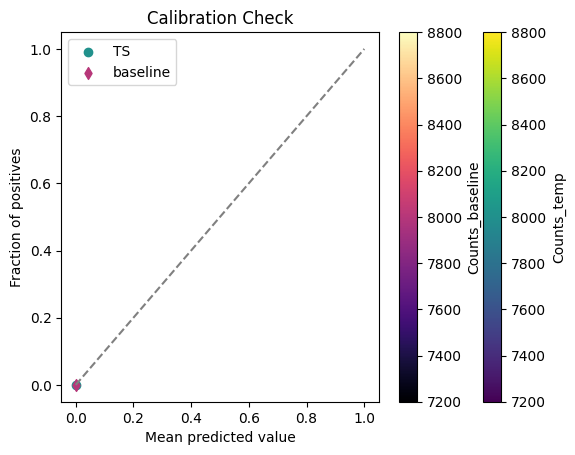


[8000]
[8000]


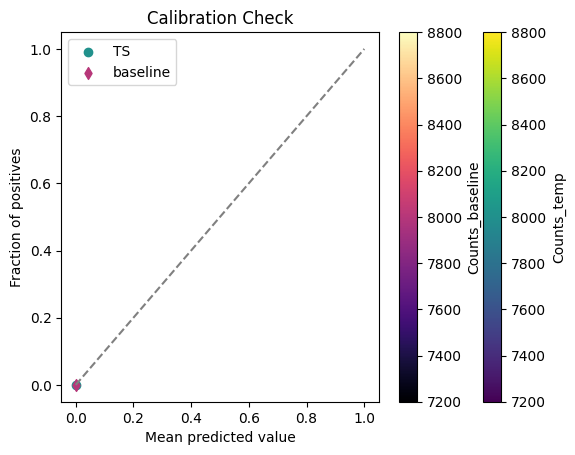


[8000]
[8000]


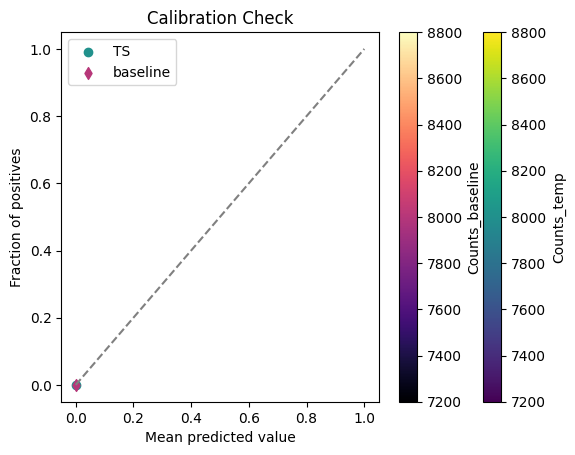


[8000]
[8000]


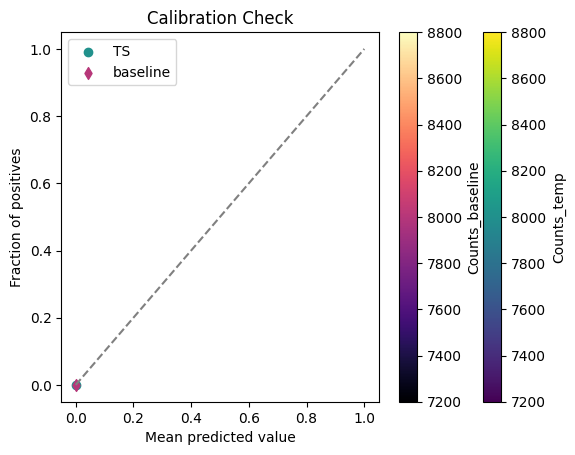


[8000]
[8000]


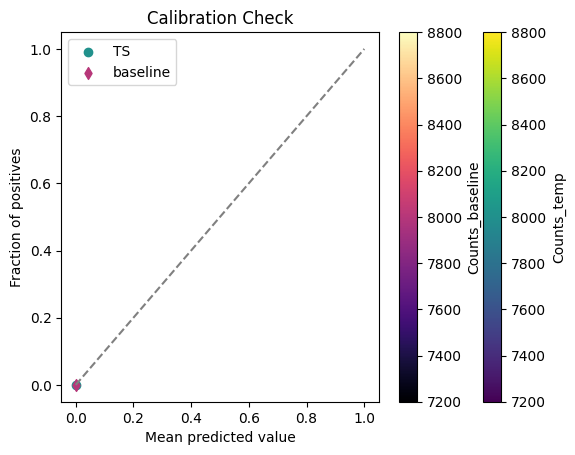


[8000]
[8000]


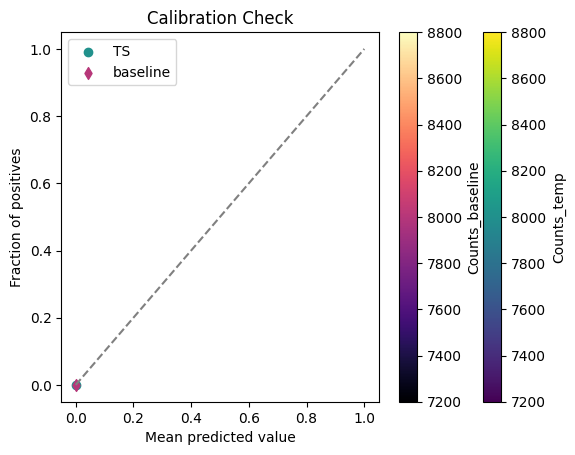


[8000]
[8000]


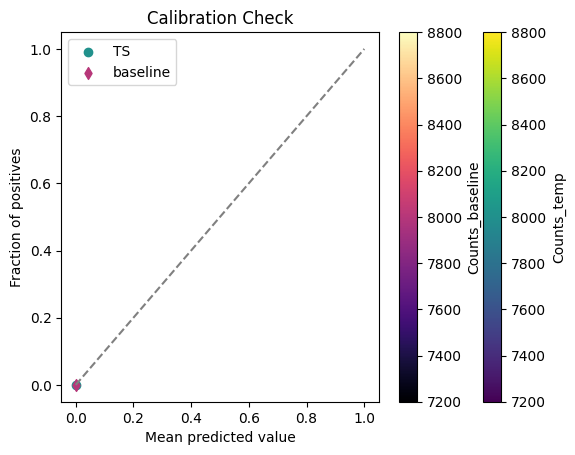


[8000]
[8000]


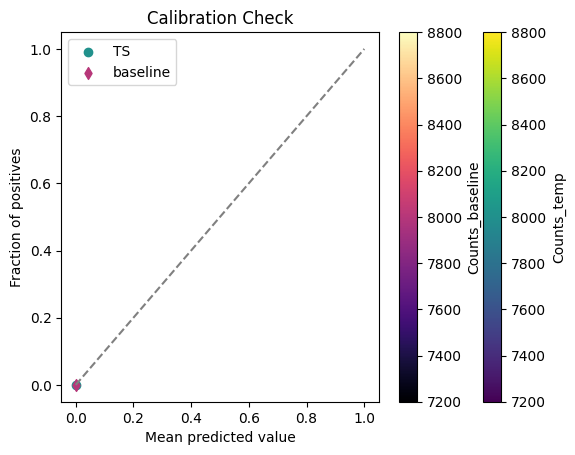


[8000]
[8000]


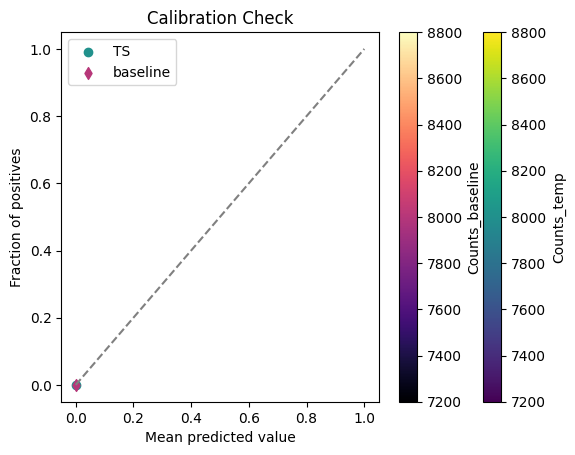


[8000]
[8000]


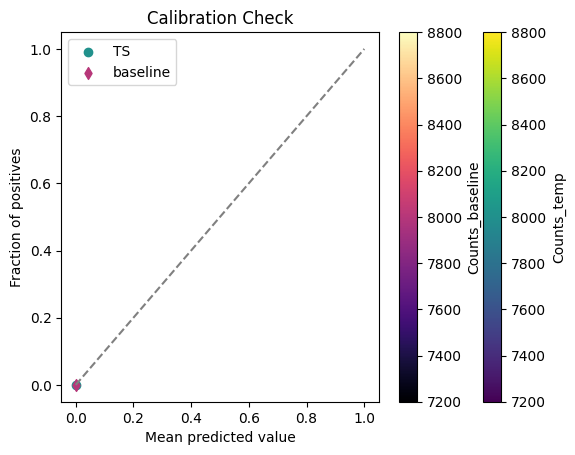


[8000]
[8000]


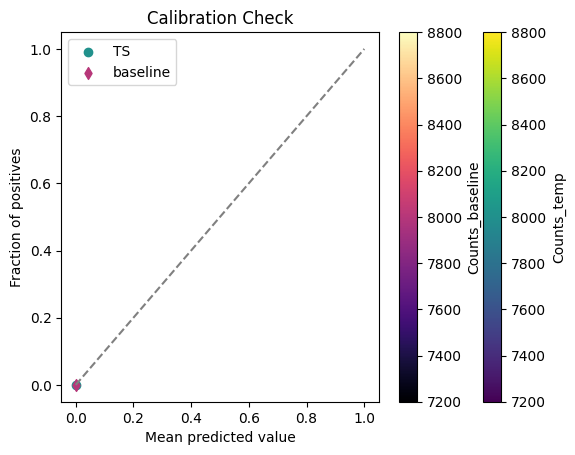


[8000]
[8000]


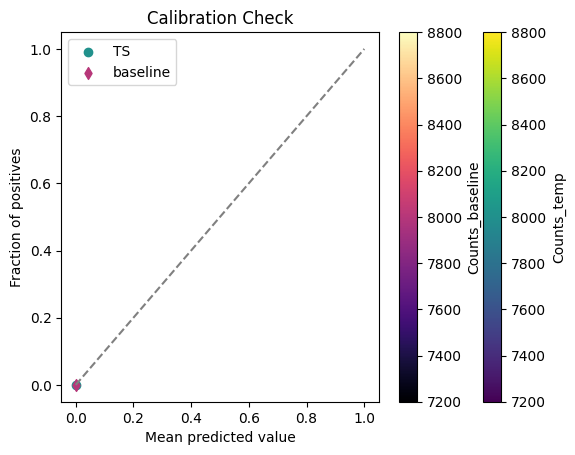


[8000]
[8000]


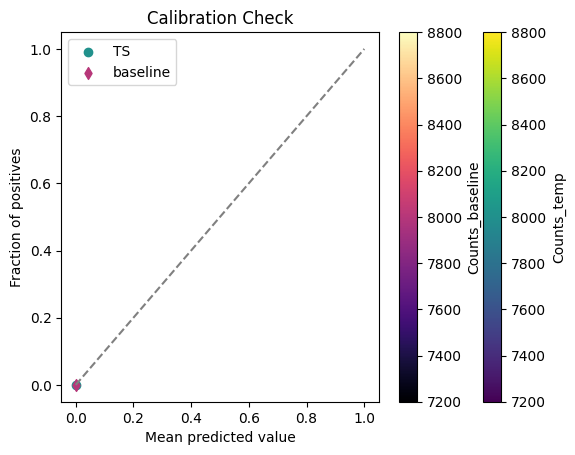


[8000]
[8000]


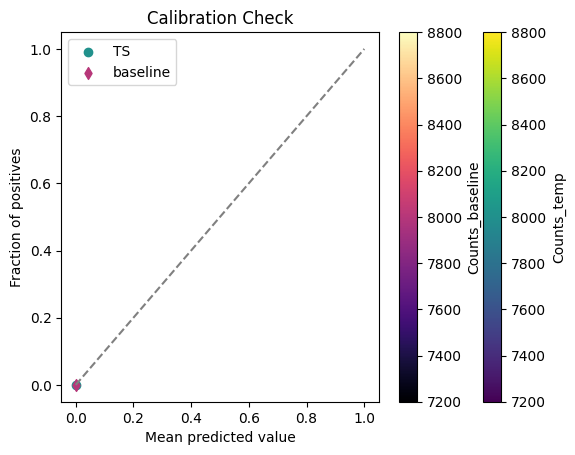


[8000]
[8000]


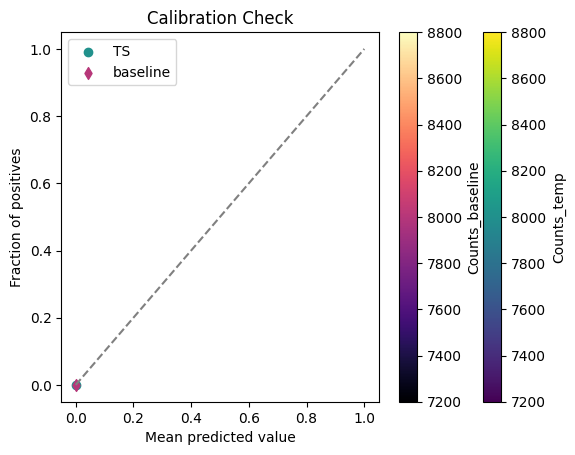


[8000]
[8000]


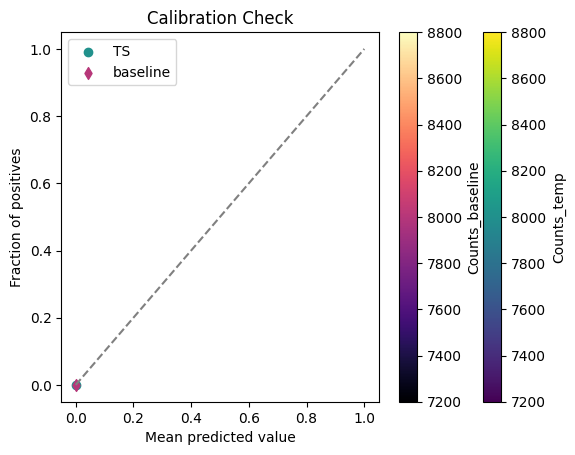


[8000]
[8000]


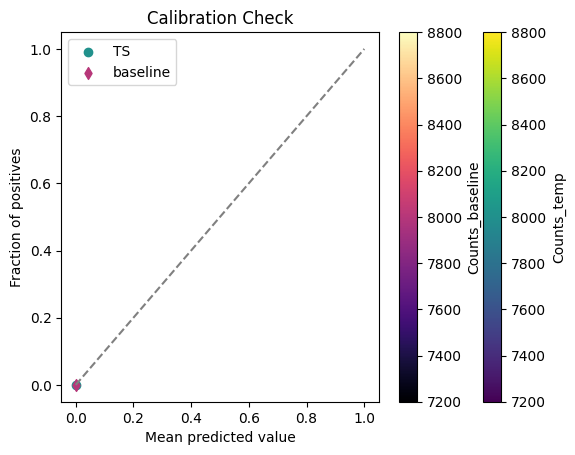


[8000]
[8000]


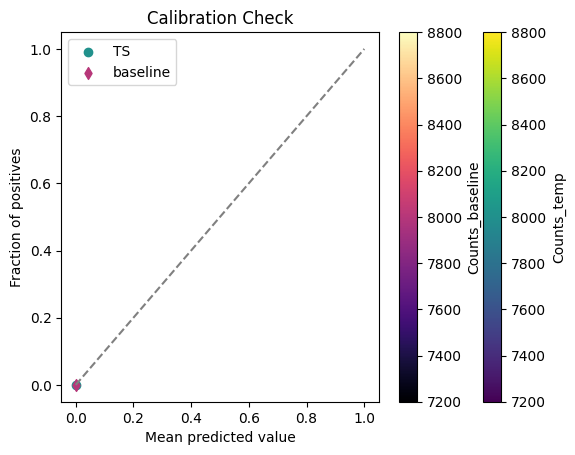


[8000]
[8000]


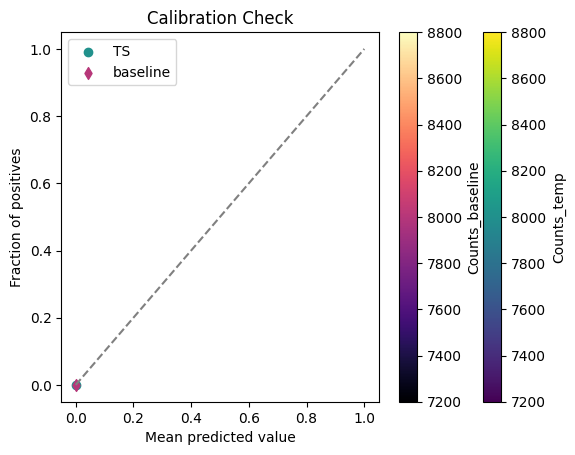

In [ ]:
for k in range(100):
  x_first_position=[]
  y_first_position=[]
  x_probs_first_position_baseline=[]
  y_probs_first_position_baseline=[]
  for i in range(len(probs_temp_y_test_copy)):
    x_first_position.append(np.max(probs_temp_y_test_copy[i]))
    x_probs_first_position_baseline.append(np.max(probs_y_test_copy[i]))
    j=np.argmax(probs_temp_y_test_copy[i])
    j2=np.argmax(probs_y_test_copy[i])
    probs_temp_y_test_copy[i,j]=-1
    probs_y_test_copy[i,j2]=-1
    y_first_position.append(y_test_hot_encoded_copy[i,j])
    y_probs_first_position_baseline.append(y_test_hot_encoded_copy_2[i,j2])
    y_test_hot_encoded_copy[i,j]=-1
    y_test_hot_encoded_copy_2[i,j2]=-1

  ModelCalibration_plot(x_first_position, y_first_position,x_probs_first_position_baseline)
  print()

